In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import json
import os
import ast
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

import wandb
api = wandb.Api()

# Pull and Dedup Data

In [2]:
setting_columns = [
    # Overall
    "tag",
    # "seed",
    "_timestamp",

    # Interventions
    "interventions", "edit", "unlearn", "compression", "model_name",

    # Editing
    "edit_set", 
    "edit_dataset", "number_of_edits",

    # Unlearning
    "rmu_layer_id",

    # Compression
    "wbits", "compression_dataset", "sparsity_ratio",
]
evaluation_columns = [
    "qa_question_count_limit",  # An artifical max number of questions to ask during evaluation. Should be none when not debugging.
    "mmlu accuracy",            # The accuracy of the model on the MMLU dataset. This measures overall model utility. Llama-3 should be ~62%
    "wmdp_bio accuracy",        # The accuracy of the model on the WMDP bio split. This is the unlearning target. Should be ~25% when RMU is applied.
    "wmdp_cyber accuracy",      # The accuracy of the model on the WMDP cyber split. This is the unlearning target. Should be ~25% when RMU is applied.
    "PPL",                      # TODO:
    "PPL edits",                # Perplexity for the edits. Should be low when editing is applied.
    "PPl QA",                   # Perplexity for the QA. Should be low when QA is applied.
    "Generalization",           # TODO: 
    "FLOPs",                    # TODO: 
    "Success recall",           # TODO:
    "Generalization recall",    # TODO:
    "Locality",                 # TODO:
    "Average bits",             # TODO:
    "Rewrite accuracy",         # TODO:
    "PPl edits unmasked",       # TODO:
    "Local recall",             # TODO:
    "Latency",                  # TODO:
]
relevant_columns = setting_columns + evaluation_columns

In [3]:
# Composable_Interventions has all the results
project_paths = [
    'dri-ice/Composable_Interventions',
    # 'dri-ice/AK_Tests'
]

filter_dict = { "state": "finished" }
data_frames = []
for project_path in project_paths:
    runs = api.runs(project_path, filters=filter_dict)
    
    # Iterate over eachrun and capture the c        onfig and summary metrics
    for run in tqdm(runs, desc=project_path):
        try:
            run_start_datetime = datetime.fromtimestamp(run.summary_metrics["_timestamp"])
            start_cutoff = datetime.strptime("2024-05-18 00:00:00", "%Y-%m-%d %H:%M:%S")
            end_cutoff = datetime.strptime("2024-06-19 00:00:00", "%Y-%m-%d %H:%M:%S")
            if run_start_datetime < start_cutoff or run_start_datetime > end_cutoff:
                continue

            skip_tags = ["test", "hparam_search"]
            should_skip = False
            for tag in skip_tags:
                if tag in run.config["tag"].lower():
                    should_skip = True
            
            if should_skip:
                continue

            config_frame = pd.DataFrame([run.config])
            summary_frame = pd.DataFrame([run.summary_metrics])
            combined_frame = pd.concat([config_frame, summary_frame], axis=1)
            data_frames.append(combined_frame)
        except Exception as e:
            print(f"Error processing run {run.id}: {e}")

# Sort by 'tag' and '_timestamp' in descending order to have the most recent run first
all_runs_df = pd.concat(data_frames, ignore_index=True)[relevant_columns]
all_runs_df["interventions"] = all_runs_df["interventions"].astype(str)

# Keep only the current edit dataset
all_runs_df = all_runs_df[all_runs_df['edit_dataset'] == 'zsre']

# WARNING: WHAT DOES EDIT SET 50 MEAN COMPARED TO EDIT SET 1?
# all_runs_df = all_runs_df[all_runs_df["edit_set"] == 50]
# all_runs_df_sorted = all_runs_df.sort_values(by=['tag', '_timestamp'], ascending=[True, False])
all_runs_df["date"] = pd.to_datetime(all_runs_df["_timestamp"], unit='s')
all_runs_df_sorted = all_runs_df.sort_values(by=['_timestamp'], ascending=[False])
all_runs_df_sorted = all_runs_df_sorted[all_runs_df_sorted["qa_question_count_limit"].isnull()]

dri-ice/Composable_Interventions:  47%|████▋     | 2101/4471 [00:12<00:12, 193.05it/s]

Error processing run evuxnltk: '_timestamp'
Error processing run mje2wvj7: '_timestamp'
Error processing run um0dxn3y: '_timestamp'
Error processing run isna6rgu: '_timestamp'
Error processing run luhstpn5: '_timestamp'
Error processing run lrh5z3wp: '_timestamp'
Error processing run 2do500pc: '_timestamp'


dri-ice/Composable_Interventions:  48%|████▊     | 2151/4471 [00:12<00:12, 192.41it/s]

Error processing run 71jdht68: '_timestamp'
Error processing run 64ed5z4t: '_timestamp'
Error processing run 1wj0u6cj: '_timestamp'
Error processing run cc3cmdlj: '_timestamp'
Error processing run 7t3n8sq1: '_timestamp'
Error processing run o1ai36xl: '_timestamp'
Error processing run 31j4yjsr: '_timestamp'
Error processing run 2nv88i8v: '_timestamp'
Error processing run sdhehb2z: '_timestamp'
Error processing run r6kpsu09: '_timestamp'
Error processing run arid375k: '_timestamp'


dri-ice/Composable_Interventions: 100%|█████████▉| 4451/4471 [00:27<00:00, 153.39it/s]

Error processing run n0iel6ok: '_timestamp'
Error processing run xr5mede5: '_timestamp'
Error processing run 27f8pxs0: '_timestamp'


dri-ice/Composable_Interventions: 100%|██████████| 4471/4471 [00:27<00:00, 164.56it/s]


In [4]:
# Sort by the recency column, for example, 'date'
all_runs_df_sorted = all_runs_df_sorted.sort_values(by='date')

# Drop duplicates, keeping only the most recent occurrence for each "tag" and "edit_set"
latest_runs_df = all_runs_df_sorted.drop_duplicates(subset=['tag', 'edit_set'], keep='last')

# Define a function to calculate standard error
def standard_error(x):
    return x.std() / np.sqrt(len(x))

# Group by the "tag" column and calculate the mean for numerical columns
grouped_df = latest_runs_df.groupby('tag').agg(['mean', standard_error])

# Flatten the multi-level columns
grouped_df.columns = [f'{col[0]}_{col[1]}' for col in grouped_df.columns]

# Split the columns into means and standard errors
mean_columns = [col for col in grouped_df.columns if col.endswith('_mean')]
se_columns = [col for col in grouped_df.columns if col.endswith('_standard_error')]

# Create separate DataFrames for means and standard errors
mean_df = grouped_df[mean_columns].rename(columns=lambda x: x.replace('_mean', ''))
se_df = grouped_df[se_columns].rename(columns=lambda x: x.replace('_standard_error', '_se'))

# Merge the means and standard errors back into one DataFrame
all_runs_df_sorted_averaged = pd.concat([mean_df, se_df], axis=1)

# Reset index if needed
all_runs_df_sorted_averaged.reset_index(inplace=True)

# Add non-numerical columns from the latest_runs_df
non_numerical_columns = latest_runs_df.select_dtypes(exclude=[np.number]).drop_duplicates(subset=['tag'])
all_runs_df_sorted_averaged = all_runs_df_sorted_averaged.merge(non_numerical_columns, on='tag', how='left')

# Display the resulting DataFrame
all_runs_df_sorted_averaged.head()

/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_74937/3599510764.py:12: FutureWarning: ['interventions', 'edit', 'unlearn', 'compression', 'model_name', 'edit_dataset', 'compression_dataset', 'PPL', 'PPL edits', 'PPl QA', 'FLOPs', 'PPl edits unmasked'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  grouped_df = latest_runs_df.groupby('tag').agg(['mean', standard_error])


,tag,_timestamp,edit_set,number_of_edits,rmu_layer_id,wbits,sparsity_ratio,qa_question_count_limit_x,mmlu accuracy,wmdp_bio accuracy,...,model_name,edit_dataset,compression_dataset,qa_question_count_limit_y,PPL,PPL edits,PPl QA,FLOPs,PPl edits unmasked,date_y
0,AWQ2bit-to-ft,1.718168e+09,9.545455,50.0,-1.0,2.0,0.0,NaN,0.258743,0.243591,...,meta-llama/Meta-Llama-3-8B,zsre,c4,None,33638.4375,338052.34375,102475.617188,-1,78554.226562,2024-05-20 17:38:54.680141568
1,AWQ2bit-to-lora,1.718359e+09,5.500000,50.0,-1.0,2.0,0.0,NaN,0.262028,0.242419,...,meta-llama/Meta-Llama-3-8B,zsre,c4,None,141960.90625,37042.675781,267692.4375,-1,93121.015625,2024-06-14 09:58:09.475097088
2,AWQ2bit-to-memit,1.718128e+09,10.666667,50.0,-1.0,2.0,0.0,NaN,0.264049,0.241424,...,meta-llama/Meta-Llama-3-8B,zsre,c4,None,1735678.75,996271.5625,1198751.125,-1,1074956.375,2024-05-20 17:01:28.464071680
3,AWQ3bit-to-ft,1.718614e+09,5.500000,50.0,-1.0,3.0,0.0,NaN,0.509479,0.594580,...,meta-llama/Meta-Llama-3-8B,zsre,c4,None,7.569585,50514.761719,627.454346,-1,945.212585,2024-06-17 08:37:00.186556416
4,AWQ3bit-to-lora,1.718611e+09,5.500000,50.0,-1.0,3.0,0.0,NaN,0.510034,0.604242,...,meta-llama/Meta-Llama-3-8B,zsre,c4,None,55.437218,334348.21875,9609.279297,-1,16729.5,2024-06-17 07:55:00.258938112


In [5]:
# Filter the DataFrame for rows where 'edit_set' is either 1 or 50
filtered_df = all_runs_df_sorted_averaged[all_runs_df_sorted_averaged['edit_set'].isin([1, 50])]

# Print the unique 'tag' values
unique_tags = filtered_df['tag'].unique()

print([tag for tag in unique_tags if "rmu" in tag])
print(unique_tags)
print(all_runs_df_sorted_averaged.shape)
print(all_runs_df_sorted.columns)
print(all_runs_df_sorted_averaged.columns)

['sparsegpt0.35\\%-rmu']
['AWQ3bit-to-memit' 'awq2bit-ga' 'awq2bit-gd' 'awq3bit-ga' 'awq3bit-gd'
 'awq4bit-ga' 'awq4bit-gd' 'awq5bit-ga' 'awq5bit-gd' 'awq6bit-ga'
 'awq6bit-gd' 'awq8bit-ga' 'awq8bit-gd' 'ga-awq2bit' 'ga-awq3bit'
 'ga-awq4bit' 'ga-awq5bit' 'ga-awq6bit' 'ga-awq8bit' 'ga-gptq2bit'
 'ga-gptq3bit' 'ga-gptq4bit' 'ga-gptq8bit' 'ga-sparsegpt0.25\\%'
 'ga-sparsegpt0.35\\%' 'ga-sparsegpt0.45\\%' 'ga-sparsegpt0.55\\%'
 'ga-sparsegpt0.65\\%' 'ga-sparsegpt0.75\\%' 'ga-wanda0.25\\%'
 'ga-wanda0.35\\%' 'ga-wanda0.45\\%' 'ga-wanda0.55\\%' 'ga-wanda0.65\\%'
 'ga-wanda0.75\\%' 'gd-awq2bit' 'gd-awq3bit' 'gd-awq4bit' 'gd-awq5bit'
 'gd-awq6bit' 'gd-awq8bit' 'gd-gptq2bit' 'gd-gptq3bit' 'gd-gptq4bit'
 'gd-gptq8bit' 'gd-sparsegpt0.25\\%' 'gd-sparsegpt0.35\\%'
 'gd-sparsegpt0.45\\%' 'gd-sparsegpt0.55\\%' 'gd-sparsegpt0.65\\%'
 'gd-sparsegpt0.75\\%' 'gd-wanda0.25\\%' 'gd-wanda0.35\\%'
 'gd-wanda0.45\\%' 'gd-wanda0.55\\%' 'gd-wanda0.65\\%' 'gd-wanda0.75\\%'
 'gptq2bit-ga' 'gptq2bit-gd' 'gptq3bit

In [6]:
# TODO: Ensure that rmu_layer_id is 3. This was originaly set to 5, but decided to rerun the evals last minute with a better hyperparameter.
# Use older RMU experiments
# all_runs_df_sorted = all_runs_df_sorted[all_runs_df_sorted["rmu_layer_id"] != 3]

In [7]:
# Drop duplicates, keeping only the first occurrence (which is the most recent due to sorting)
# all_runs_df_deduplicated = all_runs_df_sorted.drop_duplicates(subset=[col for col in setting_columns if col not in ["_timestamp", "tag", "date"]], keep="first")
all_runs_df_deduplicated = all_runs_df_sorted_averaged.drop_duplicates(subset="tag", keep="first")
all_runs_df_deduplicated["interventions"] = all_runs_df_deduplicated["interventions"].apply(lambda x : ast.literal_eval(x))

rename_dict = {
    "meta-llama/Meta-Llama-3-8B" : "Llama-3 (8b)",
    "ft" : "Fine-tune",
    "memit" : "MEMIT",
    "lora" : "LoRA",
    "wanda" : "Wanda",
    "sparsegpt" : "SparseGPT",
    "gptq" : "GPTQ",
    "awq" : "AWQ",
    "rmu" : "RMU",
    "ga" : "GA",
    "gd" : "GD",
}
metrics = all_runs_df_deduplicated
metrics["model_name"] = metrics["model_name"].apply(lambda x : rename_dict.get(x, None))
metrics["edit"] = metrics["edit"].apply(lambda x : rename_dict.get(x, None))
metrics["compression"] = metrics["compression"].apply(lambda x : rename_dict.get(x, None))
metrics["unlearn"] = metrics["unlearn"].apply(lambda x : rename_dict.get(x, None))
all_runs_df_deduplicated = metrics
display(all_runs_df_deduplicated.value_counts("tag"))
print(f"Number of experiments: {len(all_runs_df_deduplicated)}")

tag
AWQ2bit-to-ft             1
lora-to-GPTQ2bit          1
lora-to-SparseGPT0.55%    1
lora-to-SparseGPT0.45%    1
lora-to-SparseGPT0.35%    1
                         ..
awq6bit-gd                1
awq6bit-ga                1
awq5bit-rmu               1
awq5bit-gd                1
wanda0.75\%-rmu           1
Length: 309, dtype: int64

Number of experiments: 309


In [8]:
# TODO: Get a second pair of eyes on this this math

# Math for determining number of interventions
awq_settings = 6
gptq_settings = 4 # only support quantize to [2, 3, 4, 8] bits.
wanda_count = 6
sparsegpt_count = 6
editor_settings = 3
composition_factor = 2

editor_count = composition_factor * (awq_settings + gptq_settings + wanda_count + sparsegpt_count + 1) * editor_settings
print(editor_count // 2)

rmu_count = composition_factor * (awq_settings + gptq_settings + wanda_count + sparsegpt_count + editor_settings)
print(rmu_count)

69
50


In [9]:
data = all_runs_df_deduplicated

categories = {
    "No Intervention": data[data["interventions"].apply(lambda x: x == [])].copy(),
    "Editing": data[data["interventions"].apply(lambda x: x == ["edit"])].copy(),
    "Compression": data[data["interventions"].apply(lambda x: x == ["compress"])].copy(),
    "Edit to Compression": data[data["interventions"].apply(lambda x: x == ["edit", "compress"])].copy(),
    "Compression to Edit": data[data["interventions"].apply(lambda x: x == ["compress", "edit"])].copy(),
    "Unlearn": data[data["interventions"].apply(lambda x: x == ["unlearn"])].copy(),
    "Edit to Unlearn": data[data["interventions"].apply(lambda x: x == ["edit", "unlearn"])].copy(),
    "Unlearn to Edit": data[data["interventions"].apply(lambda x: x == ["unlearn", "edit"])].copy(),
    "Compress to Unlearn": data[data["interventions"].apply(lambda x: x == ["compress", "unlearn"])].copy(),
    "Unlearn to Compress": data[data["interventions"].apply(lambda x: x == ["unlearn", "compress"])].copy()
}

assert len(categories["No Intervention"]) == 1, f"{len(categories['No Intervention'])} != 1"
assert len(categories["Editing"]) == 3, f"{len(categories['Editing'])} != 3"

# display(categories["Compression"])
assert len(categories["Compression"]) == (awq_settings + gptq_settings + wanda_count + sparsegpt_count), f"{len(categories['Compression'])} != {awq_settings + gptq_settings + wanda_count + sparsegpt_count}"

# assert len(categories["Edit to Compression"]) == editor_count // 2, f"{len(categories['Edit to Compression'])} != {editor_count // 2}"

assert len(categories["Compression to Edit"]) == (editor_count // 2 )- 3, f"{len(categories['Compression to Edit'])} != {editor_count // 2}" # TODO: Fix this by getting the latest results
assert len(categories["Unlearn"]) == 1, f"{len(categories['Unlearn'])} != 1"
assert len(categories["Edit to Unlearn"]) == 9
assert len(categories["Unlearn to Edit"]) == 9, f"{len(categories['Unlearn to Edit'])} != 3"

# display(categories["Compress to Unlearn"])
# assert len(categories["Compress to Unlearn"]) == rmu_count // 2, f"{len(categories['Compress to Unlearn'])} != {rmu_count // 2}"

# display(categories["Unlearn to Compress"])
# assert len(categories["Unlearn to Compress"]) == rmu_count // 2, f"{len(categories['Unlearn to Compress'])} != {rmu_count // 2}"


# Create Results Tables

In [10]:
# def format_flops(value):
#     """ Format FLOPs with three significant figures and appropriate suffix. """
#     try:
#         if isinstance(value, str):
#             value = clean_numeric_value(value)
#         if abs(value) < 1e6:  # Less than 1 million (below Mega)
#             return "{:.3g}k".format(value / 1e3)
#         elif abs(value) < 1e9:  # Mega to Giga range
#             return "{:.3g}M".format(value / 1e6)
#         elif abs(value) < 1e12:  # Giga to Tera range
#             return "{:.3g}G".format(value / 1e9)
#         else:  # Tera and above
#             return "{:.3g}T".format(value / 1e12)
#     except Exception as e:
#         print(f"Error formatting FLOPs value {value}: {e}")
#         return "---"

# def escape_latex_special_chars(s):
#     """ Escape special characters in LaTeX strings. """
#     return str(s).replace('%', '\\%').replace('_', '\\_').replace('&', '\\&').replace('#', '\\#').replace('$', '\\$')

# def clean_numeric_value(value):
#     """ Convert a string with units to a numeric value. """
#     try:
#         value = str(value)
#         if ' TFLOPS' in value:
#             return float(value.replace(' TFLOPS', '')) * 1e12
#         if ' GFLOPS' in value:
#             return float(value.replace(' GFLOPS', '')) * 1e9
#         if ' MFLOPS' in value:
#             return float(value.replace(' MFLOPS', '')) * 1e6
#         if ' kFLOPS' in value:
#             return float(value.replace(' kFLOPS', '')) * 1e3
#         return pd.to_numeric(value, errors='coerce')
#     except Exception as e:
#         print(f"Error cleaning value {value}: {e}")
#         return pd.NA

# def categorize_and_generate_latex(data):
#     # Define categories based on the provided criteria
#     categories = {
#     "No Intervention": data[data['interventions'].apply(lambda x: x == [])].copy(),
#     "Editing": data[data['interventions'].apply(lambda x: x == ['edit'])].copy(),
#     "Compression": data[data['interventions'].apply(lambda x: x == ['compress'])].copy(),
#     "Edit to Compression": data[data['interventions'].apply(lambda x: x == ['edit', 'compress'])].copy(),
#     "Compression to Edit": data[data['interventions'].apply(lambda x: x == ['compress', 'edit'])].copy(),
#     "Unlearn": data[data['interventions'].apply(lambda x: x == ['unlearn'])].copy(),
#     "Edit to Unlearn": data[data['interventions'].apply(lambda x: x == ['edit', 'unlearn'])].copy(),
#     "Unlearn to Edit": data[data['interventions'].apply(lambda x: x == ['unlearn', 'edit'])].copy(),
#     "Compress to Unlearn": data[data['interventions'].apply(lambda x: x == ['compress', 'unlearn'])].copy(),
#     "Unlearn to Compress": data[data['interventions'].apply(lambda x: x == ['unlearn', 'compress'])].copy()
# }
#     # Clean numeric columns
#     for col in ["FLOPs", "Latency"]:
#         if col in data.columns:
#             data.loc[:, col] = data[col].apply(clean_numeric_value)
#             data.loc[:, col] = pd.to_numeric(data[col], errors='coerce')  # Ensure all values are numeric

#     # Column mappings
#     column_mappings = {
#         "Success": "Rewrite accuracy",
#         "Generalization": "Generalization",
#         "Locality": "Locality",
#         "Avg. Bits": "Average bits",
#         "FLOPs": "FLOPs",
#         "PPL": "PPL",
#         "MMLU": "mmlu accuracy",
#         "WMDP Bio": "wmdp_bio accuracy",
#         "WMDP Cyber": "wmdp_cyber accuracy"
#     }
#     latex_columns = ["Success", "Generalization", "Locality", "Avg. Bits", "FLOPs", "PPL", "MMLU", "WMDP Bio", "WMDP Cyber"]

#     # Initialize output string
#     output_str = ""

#     for category, group in categories.items():
#         if group.empty:
#             continue
#         # output_str += f"\\textbf{{{category}}} \\\\ \\midline\n"
#         for _, row in group.iterrows():
#             # Calculate mean and std for each relevant column within the group
#             stats = {}
#             for latex_col, csv_col in column_mappings.items():
#                 if csv_col in row.index:
#                     value = row[csv_col]
#                     if pd.isna(value):
#                         stats[latex_col] = "---"
#                     else:
#                         # Custom formatting for FLOPs and Latency
#                         if latex_col == "FLOPs":
#                             mean_str = format_flops(value)
#                             stats[latex_col] = escape_latex_special_chars(mean_str)
#                         elif latex_col == "Latency":
#                             mean_str = f"{value:.3f}s"
#                             stats[latex_col] = escape_latex_special_chars(mean_str)
#                         else:
#                             mean_str = f"{value:.3f}"
#                             stats[latex_col] = escape_latex_special_chars(mean_str)
#                 else:
#                     stats[latex_col] = "---"

#             # Prepare the LaTeX row for the current group
#             latex_row = escape_latex_special_chars(row['tag'])  # Use the tag name directly without escaping
#             for column in latex_columns:
#                 latex_row += " & " + stats.get(column, "---")
#             latex_row += " \\\\"

#             # Append to output string
#             output_str += latex_row + "\n"
        
#         output_str += "\\midrule\n"

#     return output_str

# latex_rows_with_categories = categorize_and_generate_latex(all_runs_df_deduplicated)
# print(latex_rows_with_categories)

# Create Plots

## Plot: Composability Heatmaps

In [28]:
# Define intervention names and types
intervention_names = [intervention for intervention in list(data["edit"].unique()) + list(data["unlearn"].unique()) + list(data["compression"].unique()) if intervention is not None]
intervention_type = {
    "LoRA": "edit",
    "MEMIT": "edit",
    "Fine-tune": "edit",
    "SparseGPT": "compression",
    "Wanda": "compression",
    "GPTQ": "compression",
    "AWQ": "compression",
    "RMU": "unlearn",
    "GA": "unlearn",
    "GD": "unlearn",
}

# Initialize heatmap data frames with default values
default_value = None
mmlu_heatmap_data = pd.DataFrame(index=intervention_names, columns=intervention_names, dtype=float, data=default_value)
wmdp_heatmap_data = pd.DataFrame(index=intervention_names, columns=intervention_names, dtype=float, data=default_value)
rewrite_heatmap_data = pd.DataFrame(index=intervention_names, columns=intervention_names, dtype=float, data=default_value)
generalization_heatmap_data = pd.DataFrame(index=intervention_names, columns=intervention_names, dtype=float, data=default_value)

# Initialize max value data frames
mmlu_max_data = pd.DataFrame(index=intervention_names, columns=intervention_names, dtype=float, data=default_value)
wmdp_max_data = pd.DataFrame(index=intervention_names, columns=intervention_names, dtype=float, data=default_value)
rewrite_max_data = pd.DataFrame(index=intervention_names, columns=intervention_names, dtype=float, data=default_value)
generalization_max_data = pd.DataFrame(index=intervention_names, columns=intervention_names, dtype=float, data=default_value)

# Populate the heatmap and max value data frames
for first_intervention in intervention_names:
    for second_intervention in intervention_names:
        first_intervention_type = intervention_type[first_intervention]
        second_intervention_type = intervention_type[second_intervention]
        if first_intervention_type == second_intervention_type:
            continue

        compositions = data[(data[first_intervention_type] == first_intervention) & (data[second_intervention_type] == second_intervention)]
        if first_intervention in ["SparseGPT", "Wanda"] or second_intervention in ["SparseGPT", "Wanda"]:
            compositions = compositions[compositions["sparsity_ratio"] == 0.25]
        elif first_intervention in ["GPTQ", "AWQ"] or second_intervention in ["GPTQ", "AWQ"]:
            compositions = compositions[compositions["wbits"] == 4]
        
        assert len(compositions) == 2, f"Expected 2 compositions for {first_intervention} and {second_intervention}, but found {len(compositions)}"
        
        # Calculate differences
        mmlu_diff = abs(compositions["mmlu accuracy"].iloc[0] - compositions["mmlu accuracy"].iloc[1]).round(4)
        mmlu_heatmap_data[first_intervention][second_intervention] = mmlu_diff
        
        avg_wmdp_diff = abs(((compositions.iloc[0]["wmdp_cyber accuracy"] + compositions.iloc[0]["wmdp_bio accuracy"]) / 2) - ((compositions.iloc[1]["wmdp_cyber accuracy"] + compositions.iloc[1]["wmdp_bio accuracy"]) / 2)).round(4)
        wmdp_heatmap_data[first_intervention][second_intervention] = avg_wmdp_diff
        
        rewrite_diff = abs(compositions["Rewrite accuracy"].iloc[0] - compositions["Rewrite accuracy"].iloc[1]).round(4)
        rewrite_heatmap_data[first_intervention][second_intervention] = rewrite_diff

        generalization_diff = abs(compositions["Generalization"].iloc[0] - compositions["Generalization"].iloc[1]).round(4)
        generalization_heatmap_data[first_intervention][second_intervention] = generalization_diff
        
        # Calculate max values
        mmlu_max = max(compositions["mmlu accuracy"].iloc[0], compositions["mmlu accuracy"].iloc[1]).round(4)
        mmlu_max_data[first_intervention][second_intervention] = mmlu_max
        
        avg_wmdp_max = min((compositions.iloc[0]["wmdp_cyber accuracy"] + compositions.iloc[0]["wmdp_bio accuracy"]) / 2, (compositions.iloc[1]["wmdp_cyber accuracy"] + compositions.iloc[1]["wmdp_bio accuracy"]) / 2).round(4)
        wmdp_max_data[first_intervention][second_intervention] = avg_wmdp_max
        
        rewrite_max = max(compositions["Rewrite accuracy"].iloc[0], compositions["Rewrite accuracy"].iloc[1]).round(4)
        rewrite_max_data[first_intervention][second_intervention] = rewrite_max

        generalization_max = max(compositions["Generalization"].iloc[0], compositions["Generalization"].iloc[1]).round(4)
        generalization_max_data[first_intervention][second_intervention] = generalization_max

# Display the results
print("MMLU Difference")
display(mmlu_heatmap_data)

print("MMLU Max Values")
display(mmlu_max_data)

print("WMDP Difference")
display(wmdp_heatmap_data)

print("WMDP Max Values")
display(wmdp_max_data)

print("Rewrite Difference")
display(rewrite_heatmap_data)

print("Rewrite Max Values")
display(rewrite_max_data)

print("Generalization Difference")
display(generalization_heatmap_data)

print("Generalization Max Values")
display(generalization_max_data)

MMLU Difference


,Fine-tune,LoRA,MEMIT,GA,GD,RMU,AWQ,GPTQ,SparseGPT,Wanda
Fine-tune,NaN,NaN,NaN,0.9929,0.8180,0.9878,0.9833,0.9968,0.9963,0.9957
LoRA,NaN,NaN,NaN,0.9294,0.8586,0.9610,0.9977,0.9880,0.9999,0.9991
MEMIT,NaN,NaN,NaN,0.9591,0.7775,0.9975,0.9916,0.9861,0.9952,0.9967
GA,0.9929,0.9294,0.9591,NaN,NaN,NaN,0.9826,0.9079,0.9420,0.9766
GD,0.8180,0.8586,0.7775,NaN,NaN,NaN,0.9300,0.7602,0.9073,0.9900
RMU,0.9878,0.9610,0.9975,NaN,NaN,NaN,0.9915,0.9500,0.9920,0.9852
AWQ,0.9833,0.9977,0.9916,0.9826,0.9300,0.9915,NaN,NaN,NaN,NaN
GPTQ,0.9968,0.9880,0.9861,0.9079,0.7602,0.9500,NaN,NaN,NaN,NaN
SparseGPT,0.9963,0.9999,0.9952,0.9420,0.9073,0.9920,NaN,NaN,NaN,NaN
Wanda,0.9957,0.9991,0.9967,0.9766,0.9900,0.9852,NaN,NaN,NaN,NaN


MMLU Max Values


,Fine-tune,LoRA,MEMIT,GA,GD,RMU,AWQ,GPTQ,SparseGPT,Wanda
Fine-tune,NaN,NaN,NaN,0.4745,0.4100,0.4305,0.4100,0.4138,0.3978,0.3979
LoRA,NaN,NaN,NaN,0.6435,0.4130,0.4443,0.4144,0.4189,0.4039,0.4036
MEMIT,NaN,NaN,NaN,0.5074,0.4207,0.4381,0.4142,0.4109,0.4037,0.4078
GA,0.4745,0.6435,0.5074,NaN,NaN,NaN,0.5347,0.5246,0.4917,0.4591
GD,0.4100,0.4130,0.4207,NaN,NaN,NaN,0.5803,0.4358,0.4227,0.4200
RMU,0.4305,0.4443,0.4381,NaN,NaN,NaN,0.4383,0.4205,0.4341,0.4288
AWQ,0.4100,0.4144,0.4142,0.5347,0.5803,0.4383,NaN,NaN,NaN,NaN
GPTQ,0.4138,0.4189,0.4109,0.5246,0.4358,0.4205,NaN,NaN,NaN,NaN
SparseGPT,0.3978,0.4039,0.4037,0.4917,0.4227,0.4341,NaN,NaN,NaN,NaN
Wanda,0.3979,0.4036,0.4078,0.4591,0.4200,0.4288,NaN,NaN,NaN,NaN


WMDP Difference


,Fine-tune,LoRA,MEMIT,GA,GD,RMU,AWQ,GPTQ,SparseGPT,Wanda
Fine-tune,NaN,NaN,NaN,0.9954,0.9999,0.9550,0.9861,0.9910,0.9957,0.9955
LoRA,NaN,NaN,NaN,0.9339,0.7563,0.9978,0.9994,0.9903,0.9981,0.9992
MEMIT,NaN,NaN,NaN,0.9492,0.9795,0.9914,0.9977,0.9950,0.9971,0.9857
GA,0.9954,0.9339,0.9492,NaN,NaN,NaN,0.9768,0.9120,0.9700,0.9715
GD,0.9999,0.7563,0.9795,NaN,NaN,NaN,0.9988,0.9770,0.7782,0.8267
RMU,0.9550,0.9978,0.9914,NaN,NaN,NaN,0.9850,0.8199,0.9759,0.9668
AWQ,0.9861,0.9994,0.9977,0.9768,0.9988,0.9850,NaN,NaN,NaN,NaN
GPTQ,0.9910,0.9903,0.9950,0.9120,0.9770,0.8199,NaN,NaN,NaN,NaN
SparseGPT,0.9957,0.9981,0.9971,0.9700,0.7782,0.9759,NaN,NaN,NaN,NaN
Wanda,0.9955,0.9992,0.9857,0.9715,0.8267,0.9668,NaN,NaN,NaN,NaN


WMDP Max Values


,Fine-tune,LoRA,MEMIT,GA,GD,RMU,AWQ,GPTQ,SparseGPT,Wanda
Fine-tune,NaN,NaN,NaN,0.5336,0.7063,0.7249,0.4646,0.4577,0.4500,0.4420
LoRA,NaN,NaN,NaN,0.7238,0.7007,0.7053,0.4528,0.4659,0.4566,0.4531
MEMIT,NaN,NaN,NaN,0.6034,0.7443,0.7072,0.4484,0.4523,0.4430,0.4571
GA,0.5336,0.7238,0.6034,NaN,NaN,NaN,0.5743,0.6557,0.5682,0.5414
GD,0.7063,0.7007,0.7443,NaN,NaN,NaN,0.7566,0.7562,0.7250,0.6525
RMU,0.7249,0.7053,0.7072,NaN,NaN,NaN,0.7267,0.7333,0.7150,0.7146
AWQ,0.4646,0.4528,0.4484,0.5743,0.7566,0.7267,NaN,NaN,NaN,NaN
GPTQ,0.4577,0.4659,0.4523,0.6557,0.7562,0.7333,NaN,NaN,NaN,NaN
SparseGPT,0.4500,0.4566,0.4430,0.5682,0.7250,0.7150,NaN,NaN,NaN,NaN
Wanda,0.4420,0.4531,0.4571,0.5414,0.6525,0.7146,NaN,NaN,NaN,NaN


Rewrite Difference


,Fine-tune,LoRA,MEMIT,GA,GD,RMU,AWQ,GPTQ,SparseGPT,Wanda
Fine-tune,NaN,NaN,NaN,0.9314,0.3295,0.9910,0.9611,0.6430,0.9651,0.9730
LoRA,NaN,NaN,NaN,0.0040,0.4413,0.9996,0.9165,0.6294,0.9852,0.9202
MEMIT,NaN,NaN,NaN,0.5179,0.6008,0.9875,0.9901,0.9677,0.9633,0.7552
GA,0.9314,0.0040,0.5179,NaN,NaN,NaN,1.0000,1.0000,1.0000,1.0000
GD,0.3295,0.4413,0.6008,NaN,NaN,NaN,0.9883,0.9933,0.9956,1.0000
RMU,0.9910,0.9996,0.9875,NaN,NaN,NaN,0.9941,0.9838,0.9859,0.9995
AWQ,0.9611,0.9165,0.9901,1.0000,0.9883,0.9941,NaN,NaN,NaN,NaN
GPTQ,0.6430,0.6294,0.9677,1.0000,0.9933,0.9838,NaN,NaN,NaN,NaN
SparseGPT,0.9651,0.9852,0.9633,1.0000,0.9956,0.9859,NaN,NaN,NaN,NaN
Wanda,0.9730,0.9202,0.7552,1.0000,1.0000,0.9995,NaN,NaN,NaN,NaN


Rewrite Max Values


,Fine-tune,LoRA,MEMIT,GA,GD,RMU,AWQ,GPTQ,SparseGPT,Wanda
Fine-tune,NaN,NaN,NaN,0.9314,0.0050,0.0017,0.0062,0.2061,0.0062,0.0135
LoRA,NaN,NaN,NaN,0.0040,0.0040,0.0040,0.0040,0.4199,0.1374,0.0519
MEMIT,NaN,NaN,NaN,0.5179,0.0696,0.0313,0.0710,0.1554,0.0929,0.0541
GA,0.9314,0.0040,0.5179,NaN,NaN,NaN,1.0000,1.0000,1.0000,1.0000
GD,0.0050,0.0040,0.0696,NaN,NaN,NaN,0.9883,0.9933,0.9933,1.0000
RMU,0.0017,0.0040,0.0313,NaN,NaN,NaN,0.9759,0.9794,0.9784,0.9804
AWQ,0.0062,0.0040,0.0710,1.0000,0.9883,0.9759,NaN,NaN,NaN,NaN
GPTQ,0.2061,0.4199,0.1554,1.0000,0.9933,0.9794,NaN,NaN,NaN,NaN
SparseGPT,0.0062,0.1374,0.0929,1.0000,0.9933,0.9784,NaN,NaN,NaN,NaN
Wanda,0.0135,0.0519,0.0541,1.0000,1.0000,0.9804,NaN,NaN,NaN,NaN


Generalization Difference


,Fine-tune,LoRA,MEMIT,GA,GD,RMU,AWQ,GPTQ,SparseGPT,Wanda
Fine-tune,NaN,NaN,NaN,0.9599,0.4393,0.9715,0.9463,0.6436,0.9848,0.9619
LoRA,NaN,NaN,NaN,0.2165,0.5192,0.9607,0.8600,0.7328,0.9287,0.9941
MEMIT,NaN,NaN,NaN,0.5904,0.5923,0.9641,0.9967,0.8911,0.9653,0.7920
GA,0.9599,0.2165,0.5904,NaN,NaN,NaN,1.0000,1.0000,1.0000,1.0000
GD,0.4393,0.5192,0.5923,NaN,NaN,NaN,1.0000,0.9933,0.9933,0.9933
RMU,0.9715,0.9607,0.9641,NaN,NaN,NaN,0.9973,0.9977,0.9968,0.9943
AWQ,0.9463,0.8600,0.9967,1.0000,1.0000,0.9973,NaN,NaN,NaN,NaN
GPTQ,0.6436,0.7328,0.8911,1.0000,0.9933,0.9977,NaN,NaN,NaN,NaN
SparseGPT,0.9848,0.9287,0.9653,1.0000,0.9933,0.9968,NaN,NaN,NaN,NaN
Wanda,0.9619,0.9941,0.7920,1.0000,0.9933,0.9943,NaN,NaN,NaN,NaN


Generalization Max Values


,Fine-tune,LoRA,MEMIT,GA,GD,RMU,AWQ,GPTQ,SparseGPT,Wanda
Fine-tune,NaN,NaN,NaN,0.9599,0.1892,0.1848,0.1608,0.4010,0.2260,0.2044
LoRA,NaN,NaN,NaN,0.2165,0.2915,0.2852,0.2592,0.5944,0.4767,0.4623
MEMIT,NaN,NaN,NaN,0.5904,0.1067,0.0703,0.1095,0.1977,0.1359,0.1039
GA,0.9599,0.2165,0.5904,NaN,NaN,NaN,1.0000,1.0000,1.0000,1.0000
GD,0.1892,0.2915,0.1067,NaN,NaN,NaN,1.0000,0.9933,0.9933,0.9933
RMU,0.1848,0.2852,0.0703,NaN,NaN,NaN,0.9772,0.9801,0.9770,0.9765
AWQ,0.1608,0.2592,0.1095,1.0000,1.0000,0.9772,NaN,NaN,NaN,NaN
GPTQ,0.4010,0.5944,0.1977,1.0000,0.9933,0.9801,NaN,NaN,NaN,NaN
SparseGPT,0.2260,0.4767,0.1359,1.0000,0.9933,0.9770,NaN,NaN,NaN,NaN
Wanda,0.2044,0.4623,0.1039,1.0000,0.9933,0.9765,NaN,NaN,NaN,NaN


### Editing and Compression Subtables

In [13]:
import pandas as pd



def format_value(value):
    if pd.isnull(value):
        return ''
    elif value > .995:
        return '1'
    else:
        return f'{value:.2f}'[1:] if value < 1 else f'{value:.2f}'


def latex_bold_if_max(value: str, max_value: float):
    return f'\\textbf{{{value}}}' if value == format_value(max_value) else value


def generate_latex_table(edit_max_df, edit_diff_df, gen_max_df, gen_diff_df, mmlu_max_df, mmlu_diff_df, edit_interventions, mmlu_interventions, title, label):
    latex_code = r'''
    \begin{tabular}{lcccccccccccc}
        \toprule
        & \multicolumn{6}{c}{\textbf{Edit Success}} & \multicolumn{6}{c}{\textbf{Generalization}} \\
        \cmidrule(lr){2-7} \cmidrule(lr){8-13}
        & \multicolumn{3}{c}{\textbf{MCS}} & \multicolumn{3}{c}{\textbf{OI}} & \multicolumn{3}{c}{\textbf{MCS}} & \multicolumn{3}{c}{\textbf{OI}} \\
        \cmidrule(lr){2-4} \cmidrule(lr){5-7} \cmidrule(lr){8-10} \cmidrule(lr){11-13}
        \textbf{Method} & \textbf{FT} & \textbf{LoRA} & \textbf{MEMIT} & \textbf{FT} & \textbf{LoRA} & \textbf{MEMIT} & \textbf{FT} & \textbf{LoRA} & \textbf{MEMIT} & \textbf{FT} & \textbf{LoRA} & \textbf{MEMIT} \\
        \midrule
'''
    
    compression_interventions = ['Wanda', 'SparseGPT', 'AWQ', 'GPTQ']
    edit_success_comp_maxes = {}
    for edit_intervention in edit_interventions:
        compression_maxes = []
        for compression_intervention in compression_interventions:
            compression_maxes.append(edit_max_df.at[compression_intervention, edit_intervention])
        
        edit_success_comp_maxes[edit_intervention] = round(max(compression_maxes), ROUND_DIGITS)

    edit_succes_oi_comp_mins = {}
    for edit_intervention in edit_interventions:
        compression_diffs = []
        for compression_intervention in compression_interventions:
            compression_diffs.append(edit_diff_df.at[compression_intervention, edit_intervention])

        edit_succes_oi_comp_mins[edit_intervention] = round(min(compression_diffs), ROUND_DIGITS)

    generalization_comp_maxes = {}
    for edit_intervention in edit_interventions:
        compression_maxes = []
        for compression_intervention in compression_interventions:
            compression_maxes.append(gen_max_df.at[compression_intervention, edit_intervention])
        
        generalization_comp_maxes[edit_intervention] = round(max(compression_maxes), ROUND_DIGITS)
    
    generalization_oi_comp_mins = {}
    for edit_intervention in edit_interventions:
        compression_diffs = []
        for compression_intervention in compression_interventions:
            compression_diffs.append(gen_diff_df.at[compression_intervention, edit_intervention])

        generalization_oi_comp_mins[edit_intervention] = round(min(compression_diffs), ROUND_DIGITS)
    
    mmlu_comp_maxes = {}
    for edit_intervention in mmlu_interventions:
        compression_maxes = []
        for compression_intervention in compression_interventions:
            compression_maxes.append(mmlu_max_df.at[compression_intervention, edit_intervention])
        
        mmlu_comp_maxes[edit_intervention] = round(max(compression_maxes), ROUND_DIGITS)

    mmlu_comp_mins = {}
    for edit_intervention in mmlu_interventions:
        compression_diffs = []
        for compression_intervention in compression_interventions:
            compression_diffs.append(mmlu_diff_df.at[compression_intervention, edit_intervention])

        mmlu_comp_mins[edit_intervention] = round(min(compression_diffs), ROUND_DIGITS)

    
    for method in compression_interventions:
        latex_code += f'        \\textbf{{{method}}} '
        
        # Edit Success - MCS
        for intervention in edit_interventions:
            mcs_value = round(edit_max_df.at[method, intervention], ROUND_DIGITS)
            is_best = mcs_value == edit_success_comp_maxes[intervention]
            latex_code += f'& {format_value(mcs_value)} ' if not is_best else f'& \\textbf{{{format_value(mcs_value)}}} '
        
        # Edit Success - OI
        for intervention in edit_interventions:
            oi_value = round(edit_diff_df.at[method, intervention], ROUND_DIGITS)
            is_best = oi_value == edit_succes_oi_comp_mins[intervention]
            latex_code += f'& {format_value(oi_value)} ' if not is_best else f'& \\textbf{{{format_value(oi_value)}}} '

        # Generalization - MCS
        for intervention in edit_interventions:
            mcs_value = round(gen_max_df.at[method, intervention], ROUND_DIGITS)
            is_best = mcs_value == generalization_comp_maxes[intervention]
            latex_code += f'& {format_value(mcs_value)} ' if not is_best else f'& \\textbf{{{format_value(mcs_value)}}} '
        
        # Generalization - OI
        for intervention in edit_interventions:
            oi_value = round(gen_diff_df.at[method, intervention], ROUND_DIGITS)
            is_best = oi_value == generalization_oi_comp_mins[intervention]
            latex_code += f'& {format_value(oi_value)} ' if not is_best else f'& \\textbf{{{format_value(oi_value)}}} '
        
        # # MMLU - MCS
        # for intervention in mmlu_interventions:
        #     mcs_value = round(mmlu_max_df.at[method, intervention], ROUND_DIGITS)
        #     is_best = mcs_value == mmlu_comp_maxes[intervention]
        #     latex_code += f'& {format_value(mcs_value)} ' if not is_best else f'& \\textbf{{{format_value(mcs_value)}}} '
        
        # # MMLU - OI
        # for intervention in mmlu_interventions:
        #     oi_value = round(mmlu_diff_df.at[method, intervention], ROUND_DIGITS)
        #     is_best = oi_value == mmlu_comp_mins[intervention]
        #     latex_code += f'& {format_value(oi_value)} ' if not is_best else f'& \\textbf{{{format_value(oi_value)}}} '
        
        latex_code += '\\\\\n'
        if method == 'SparseGPT':
            latex_code += '        \\cdashlinelr{1-13}\n'
    
    # Calculate and add averages for each method
    latex_code += '        \\cdashlinelr{1-13}\n'
    latex_code += '        \\textit{Average} '

    # Calculate averages for each section and add to LaTeX code
    def calculate_averages(df, interventions, compare_interventions):
        averages = []
        for intervention in interventions:
            intervention_frame = df[intervention]

            compare_values = []
            for compared_intervention in compare_interventions:
                compare_values.append(intervention_frame[compared_intervention])
            averages.append(np.array(compare_values).mean())
        return averages

    # Averages for Edit Success - MCS and OI
    compression_inteventions = ['AWQ', 'GPTQ', 'SparseGPT', 'Wanda']
    avg_edit_mcs = calculate_averages(edit_max_df, edit_interventions, compression_inteventions)
    avg_edit_oi = calculate_averages(edit_diff_df, edit_interventions, compression_inteventions)
    avg_gen_mcs = calculate_averages(gen_max_df, edit_interventions, compression_inteventions)
    avg_gen_oi = calculate_averages(gen_diff_df, edit_interventions, compression_inteventions)
    # avg_mmlu_mcs = calculate_averages(mmlu_max_df, mmlu_interventions, compression_inteventions)
    # avg_mmlu_oi = calculate_averages(mmlu_diff_df, mmlu_interventions, compression_inteventions)

    # Append averages to the LaTeX code
    # for avg_value in avg_edit_mcs + avg_edit_oi + avg_gen_mcs + avg_gen_oi + avg_mmlu_mcs + avg_mmlu_oi:
    for avg_value in avg_edit_mcs + avg_edit_oi + avg_gen_mcs + avg_gen_oi:
        avg_val_str = format_value(avg_value)
        latex_code += f'& {avg_val_str} '

    # Now begin adding centered subtable for MMLU. The rows are the same as the previous table, but the columns have padding to the left and right so as to center the subtable.
    latex_code += "\\\\ \n        " + "\midrule\n"
    latex_code += r'''        \multicolumn{13}{c}{\textbf{MMLU}} \\
        \cmidrule(lr){1-13}
        & \multicolumn{3}{c}{\textbf{MCS}} & \multicolumn{3}{c}{\textbf{OI}} \\
        \cmidrule(lr){2-4} \cmidrule(lr){5-7}
        & \textbf{FT} & \textbf{LoRA} & \textbf{MEMIT} & \textbf{FT} & \textbf{LoRA} & \textbf{MEMIT} \\
        \midrule
'''

    latex_code += '\\\\\n'
    
    latex_code += r'''        \bottomrule
    \end{tabular}
'''
    
    return latex_code

# Assuming rewrite_max_data, rewrite_heatmap_data, mmlu_max_data, and mmlu_heatmap_data are defined dataframes
# Assuming generalization_max_data and generalization_heatmap_data are defined dataframes
edit_interventions = ['Fine-tune', 'LoRA', 'MEMIT']
mmlu_interventions = ['Fine-tune', 'LoRA', 'MEMIT']
title = "Editing and Compression"
label = "tab:edit_compress"

latex_table_code = generate_latex_table(rewrite_max_data, rewrite_heatmap_data, generalization_max_data, generalization_heatmap_data, mmlu_max_data, mmlu_heatmap_data, edit_interventions, mmlu_interventions, title, label)
print(latex_table_code)


    \begin{tabular}{lcccccccccccc}
        \toprule
        & \multicolumn{6}{c}{\textbf{Edit Success}} & \multicolumn{6}{c}{\textbf{Generalization}} \\
        \cmidrule(lr){2-7} \cmidrule(lr){8-13}
        & \multicolumn{3}{c}{\textbf{MCS}} & \multicolumn{3}{c}{\textbf{OI}} & \multicolumn{3}{c}{\textbf{MCS}} & \multicolumn{3}{c}{\textbf{OI}} \\
        \cmidrule(lr){2-4} \cmidrule(lr){5-7} \cmidrule(lr){8-10} \cmidrule(lr){11-13}
        \textbf{Method} & \textbf{FT} & \textbf{LoRA} & \textbf{MEMIT} & \textbf{FT} & \textbf{LoRA} & \textbf{MEMIT} & \textbf{FT} & \textbf{LoRA} & \textbf{MEMIT} & \textbf{FT} & \textbf{LoRA} & \textbf{MEMIT} \\
        \midrule
        \textbf{Wanda} & \textbf{.99} & .95 & \textbf{.95} & \textbf{.03} & .08 & .24 & .80 & .54 & \textbf{.90} & .04 & \textbf{.01} & .21 \\
        \textbf{SparseGPT} & \textbf{.99} & .86 & .91 & \textbf{.03} & \textbf{.01} & .04 & .77 & .52 & .86 & \textbf{.02} & .07 & .03 \\
        \cdashlinelr{1-13}
        \textbf{AWQ} & 

### Editing and Compresion Single Row

In [14]:
import pandas as pd

ROUND_DIGITS = 2

def format_value(value):
    if pd.isnull(value):
        return ''
    elif value > .995:
        return '1'
    else:
        return f'{value:.2f}'[1:] if value < 1 else f'{value:.2f}'


def latex_bold_if_max(value: str, max_value: float):
    return f'\\textbf{{{value}}}' if value == format_value(max_value) else value


def generate_latex_table(edit_max_df, edit_diff_df, gen_max_df, gen_diff_df, mmlu_max_df, mmlu_diff_df, edit_interventions, mmlu_interventions, title, label):
    latex_code = r'''
    \begin{tabular}{lcccccccccccccccccc}
        \toprule
        & \multicolumn{6}{c}{\textbf{Edit Success}} & \multicolumn{6}{c}{\textbf{Generalization}} & \multicolumn{6}{c}{\textbf{MMLU}}\\
        \cmidrule(lr){2-7} \cmidrule(lr){8-13} \cmidrule(lr){14-19}
        & \multicolumn{3}{c}{\textbf{MCS}} & \multicolumn{3}{c}{\textbf{OI}} & \multicolumn{3}{c}{\textbf{MCS}} & \multicolumn{3}{c}{\textbf{OI}} & \multicolumn{3}{c}{\textbf{MCS}} & \multicolumn{3}{c}{\textbf{OI}}\\
        \cmidrule(lr){2-4} \cmidrule(lr){5-7} \cmidrule(lr){8-10} \cmidrule(lr){11-13} \cmidrule(lr){14-16} \cmidrule(lr){17-19}
        \textbf{Method} & \textbf{Finetune} & \textbf{LoRA} & \textbf{MEMIT} & \textbf{Finetune} & \textbf{LoRA} & \textbf{MEMIT} & \textbf{Finetune} & \textbf{LoRA} & \textbf{MEMIT} & \textbf{Finetune} & \textbf{LoRA} & \textbf{MEMIT} & \textbf{Finetune} & \textbf{LoRA} & \textbf{MEMIT} & \textbf{Finetune} & \textbf{LoRA} & \textbf{MEMIT}\\
        \midrule
'''
    
    compression_interventions = ['Wanda', 'SparseGPT', 'AWQ', 'GPTQ']
    edit_success_comp_maxes = {}
    for edit_intervention in edit_interventions:
        compression_maxes = []
        for compression_intervention in compression_interventions:
            compression_maxes.append(edit_max_df.at[compression_intervention, edit_intervention])
        
        edit_success_comp_maxes[edit_intervention] = round(max(compression_maxes), ROUND_DIGITS)

    edit_succes_oi_comp_mins = {}
    for edit_intervention in edit_interventions:
        compression_diffs = []
        for compression_intervention in compression_interventions:
            compression_diffs.append(edit_diff_df.at[compression_intervention, edit_intervention])

        edit_succes_oi_comp_mins[edit_intervention] = round(min(compression_diffs), ROUND_DIGITS)

    generalization_comp_maxes = {}
    for edit_intervention in edit_interventions:
        compression_maxes = []
        for compression_intervention in compression_interventions:
            compression_maxes.append(gen_max_df.at[compression_intervention, edit_intervention])
        
        generalization_comp_maxes[edit_intervention] = round(max(compression_maxes), ROUND_DIGITS)
    
    generalization_oi_comp_mins = {}
    for edit_intervention in edit_interventions:
        compression_diffs = []
        for compression_intervention in compression_interventions:
            compression_diffs.append(gen_diff_df.at[compression_intervention, edit_intervention])

        generalization_oi_comp_mins[edit_intervention] = round(min(compression_diffs), ROUND_DIGITS)
    
    mmlu_comp_maxes = {}
    for edit_intervention in mmlu_interventions:
        compression_maxes = []
        for compression_intervention in compression_interventions:
            compression_maxes.append(mmlu_max_df.at[compression_intervention, edit_intervention])
        
        mmlu_comp_maxes[edit_intervention] = round(max(compression_maxes), ROUND_DIGITS)

    mmlu_comp_mins = {}
    for edit_intervention in mmlu_interventions:
        compression_diffs = []
        for compression_intervention in compression_interventions:
            compression_diffs.append(mmlu_diff_df.at[compression_intervention, edit_intervention])

        mmlu_comp_mins[edit_intervention] = round(min(compression_diffs), ROUND_DIGITS)

    
    for method in compression_interventions:
        latex_code += f'        \\textbf{{{method}}} '
        
        # Edit Success - MCS
        for intervention in edit_interventions:
            mcs_value = round(edit_max_df.at[method, intervention], ROUND_DIGITS)
            is_best = mcs_value == edit_success_comp_maxes[intervention]
            latex_code += f'& {format_value(mcs_value)} ' if not is_best else f'& \\textbf{{{format_value(mcs_value)}}} '
        
        # Edit Success - OI
        for intervention in edit_interventions:
            oi_value = round(edit_diff_df.at[method, intervention], ROUND_DIGITS)
            is_best = oi_value == edit_succes_oi_comp_mins[intervention]
            latex_code += f'& {format_value(oi_value)} ' if not is_best else f'& \\textbf{{{format_value(oi_value)}}} '

        # Generalization - MCS
        for intervention in edit_interventions:
            mcs_value = round(gen_max_df.at[method, intervention], ROUND_DIGITS)
            is_best = mcs_value == generalization_comp_maxes[intervention]
            latex_code += f'& {format_value(mcs_value)} ' if not is_best else f'& \\textbf{{{format_value(mcs_value)}}} '
        
        # Generalization - OI
        for intervention in edit_interventions:
            oi_value = round(gen_diff_df.at[method, intervention], ROUND_DIGITS)
            is_best = oi_value == generalization_oi_comp_mins[intervention]
            latex_code += f'& {format_value(oi_value)} ' if not is_best else f'& \\textbf{{{format_value(oi_value)}}} '
        
        # MMLU - MCS
        for intervention in mmlu_interventions:
            mcs_value = round(mmlu_max_df.at[method, intervention], ROUND_DIGITS)
            is_best = mcs_value == mmlu_comp_maxes[intervention]
            latex_code += f'& {format_value(mcs_value)} ' if not is_best else f'& \\textbf{{{format_value(mcs_value)}}} '
        
        # MMLU - OI
        for intervention in mmlu_interventions:
            oi_value = round(mmlu_diff_df.at[method, intervention], ROUND_DIGITS)
            is_best = oi_value == mmlu_comp_mins[intervention]
            latex_code += f'& {format_value(oi_value)} ' if not is_best else f'& \\textbf{{{format_value(oi_value)}}} '
        
        latex_code += '\\\\\n'
        if method == 'SparseGPT':
            latex_code += '        \\cdashlinelr{1-19}\n'
    
    # Calculate and add averages for each method
    latex_code += '        \\cdashlinelr{1-19}\n'
    latex_code += '        \\textit{Average} '

    # Calculate averages for each section and add to LaTeX code
    def calculate_averages(df, interventions, compare_interventions):
        averages = []
        for intervention in interventions:
            intervention_frame = df[intervention]

            compare_values = []
            for compared_intervention in compare_interventions:
                compare_values.append(intervention_frame[compared_intervention])
            averages.append(np.array(compare_values).mean())
        return averages

    # Averages for Edit Success - MCS and OI
    compression_inteventions = ['AWQ', 'GPTQ', 'SparseGPT', 'Wanda']
    avg_edit_mcs = calculate_averages(edit_max_df, edit_interventions, compression_inteventions)
    avg_edit_oi = calculate_averages(edit_diff_df, edit_interventions, compression_inteventions)
    avg_gen_mcs = calculate_averages(gen_max_df, edit_interventions, compression_inteventions)
    avg_gen_oi = calculate_averages(gen_diff_df, edit_interventions, compression_inteventions)
    avg_mmlu_mcs = calculate_averages(mmlu_max_df, mmlu_interventions, compression_inteventions)
    avg_mmlu_oi = calculate_averages(mmlu_diff_df, mmlu_interventions, compression_inteventions)

    # Append averages to the LaTeX code
    for avg_value in avg_edit_mcs + avg_edit_oi + avg_gen_mcs + avg_gen_oi + avg_mmlu_mcs + avg_mmlu_oi:
        avg_val_str = format_value(avg_value)
        latex_code += f'& {avg_val_str} '

    latex_code += '\\\\\n'
    
    latex_code += r'''        \bottomrule
    \end{tabular}
'''
    
    return latex_code

# Assuming rewrite_max_data, rewrite_heatmap_data, mmlu_max_data, and mmlu_heatmap_data are defined dataframes
# Assuming generalization_max_data and generalization_heatmap_data are defined dataframes
edit_interventions = ['Fine-tune', 'LoRA', 'MEMIT']
mmlu_interventions = ['Fine-tune', 'LoRA', 'MEMIT']
title = "Editing and Compression"
label = "tab:edit_compress"

latex_table_code = generate_latex_table(rewrite_max_data, rewrite_heatmap_data, generalization_max_data, generalization_heatmap_data, mmlu_max_data, mmlu_heatmap_data, edit_interventions, mmlu_interventions, title, label)
print(latex_table_code)


    \begin{tabular}{lcccccccccccccccccc}
        \toprule
        & \multicolumn{6}{c}{\textbf{Edit Success}} & \multicolumn{6}{c}{\textbf{Generalization}} & \multicolumn{6}{c}{\textbf{MMLU}}\\
        \cmidrule(lr){2-7} \cmidrule(lr){8-13} \cmidrule(lr){14-19}
        & \multicolumn{3}{c}{\textbf{MCS}} & \multicolumn{3}{c}{\textbf{OI}} & \multicolumn{3}{c}{\textbf{MCS}} & \multicolumn{3}{c}{\textbf{OI}} & \multicolumn{3}{c}{\textbf{MCS}} & \multicolumn{3}{c}{\textbf{OI}}\\
        \cmidrule(lr){2-4} \cmidrule(lr){5-7} \cmidrule(lr){8-10} \cmidrule(lr){11-13} \cmidrule(lr){14-16} \cmidrule(lr){17-19}
        \textbf{Method} & \textbf{Finetune} & \textbf{LoRA} & \textbf{MEMIT} & \textbf{Finetune} & \textbf{LoRA} & \textbf{MEMIT} & \textbf{Finetune} & \textbf{LoRA} & \textbf{MEMIT} & \textbf{Finetune} & \textbf{LoRA} & \textbf{MEMIT} & \textbf{Finetune} & \textbf{LoRA} & \textbf{MEMIT} & \textbf{Finetune} & \textbf{LoRA} & \textbf{MEMIT}\\
        \midrule
        \textbf{Wanda} & \text

In [26]:
import pandas as pd

def format_value(value):
    if pd.isnull(value):
        return ''
    elif value == 1:
        return '1.000'
    else:
        return f'{value:.3f}'[1:] if value < 1 else f'{value:.3f}'

def generate_latex_table(edit_max_df, edit_diff_df, gen_max_df, gen_diff_df, mmlu_max_df, mmlu_diff_df, edit_interventions, mmlu_interventions, title, label):
    latex_code = r'''\begin{table}[t]
    \centering
    \resizebox{\linewidth}{!}{
    \begin{tabular}{lcccccccccccccccccc}
        \toprule
        & \multicolumn{6}{c}{\textbf{Edit Success}} & \multicolumn{6}{c}{\textbf{Generalization}} & \multicolumn{6}{c}{\textbf{MMLU}}\\
        \cmidrule(lr){2-7} \cmidrule(lr){8-13} \cmidrule(lr){14-19}
        & \multicolumn{3}{c}{\textbf{MCS}} & \multicolumn{3}{c}{\textbf{OI}} & \multicolumn{3}{c}{\textbf{MCS}} & \multicolumn{3}{c}{\textbf{OI}} & \multicolumn{3}{c}{\textbf{MCS}} & \multicolumn{3}{c}{\textbf{OI}}\\
        \cmidrule(lr){2-4} \cmidrule(lr){5-7} \cmidrule(lr){8-10} \cmidrule(lr){11-13} \cmidrule(lr){14-16} \cmidrule(lr){17-19}
        \textbf{Method} & \textbf{Finetune} & \textbf{LoRA} & \textbf{MEMIT} & \textbf{Finetune} & \textbf{LoRA} & \textbf{MEMIT} & \textbf{Finetune} & \textbf{LoRA} & \textbf{MEMIT} & \textbf{Finetune} & \textbf{LoRA} & \textbf{MEMIT} & \textbf{Finetune} & \textbf{LoRA} & \textbf{MEMIT} & \textbf{Finetune} & \textbf{LoRA} & \textbf{MEMIT}\\
        \midrule
'''
    
    for method in ['Wanda', 'SparseGPT', 'AWQ', 'GPTQ']:
        latex_code += f'        \\textbf{{{method}}} '
        
        # Edit Success - MCS
        for intervention in edit_interventions:
            mcs_value = format_value(edit_max_df.at[method, intervention])
            latex_code += f'& {mcs_value} '
        
        # Edit Success - OI
        for intervention in edit_interventions:
            oi_value = format_value(edit_diff_df.at[method, intervention])
            latex_code += f'& {oi_value} '

        # Generalization - MCS
        for intervention in edit_interventions:
            mcs_value = format_value(gen_max_df.at[method, intervention])
            latex_code += f'& {mcs_value} '
        
        # Generalization - OI
        for intervention in edit_interventions:
            oi_value = format_value(gen_diff_df.at[method, intervention])
            latex_code += f'& {oi_value} '
        
        # MMLU - MCS
        for intervention in mmlu_interventions:
            mcs_value = format_value(mmlu_max_df.at[method, intervention])
            latex_code += f'& {mcs_value} '
        
        # MMLU - OI
        for intervention in mmlu_interventions:
            oi_value = format_value(mmlu_diff_df.at[method, intervention])
            latex_code += f'& {oi_value} '
        
        latex_code += '\\\\\n'
        if method == 'SparseGPT':
            latex_code += '        \\cdashlinelr{1-19}\n'
    
    latex_code += r'''        \bottomrule
    \end{tabular}
    }
    \caption{''' + title + r'''}
    \label{''' + label + r'''}
\end{table}
'''
    
    return latex_code

# Assuming rewrite_max_data, rewrite_heatmap_data, mmlu_max_data, and mmlu_heatmap_data are defined dataframes
# Assuming generalization_max_data and generalization_heatmap_data are defined dataframes
edit_interventions = ['Fine-tune', 'LoRA', 'MEMIT']
mmlu_interventions = ['Fine-tune', 'LoRA', 'MEMIT']
title = "Editing and Compression"
label = "tab:edit_compress"

latex_table_code = generate_latex_table(rewrite_max_data, rewrite_heatmap_data, generalization_max_data, generalization_heatmap_data, mmlu_max_data, mmlu_heatmap_data, edit_interventions, mmlu_interventions, title, label)
print(latex_table_code)

\begin{table}[t]
    \centering
    \resizebox{\linewidth}{!}{
    \begin{tabular}{lcccccccccccccccccc}
        \toprule
        & \multicolumn{6}{c}{\textbf{Edit Success}} & \multicolumn{6}{c}{\textbf{Generalization}} & \multicolumn{6}{c}{\textbf{MMLU}}\\
        \cmidrule(lr){2-7} \cmidrule(lr){8-13} \cmidrule(lr){14-19}
        & \multicolumn{3}{c}{\textbf{MCS}} & \multicolumn{3}{c}{\textbf{OI}} & \multicolumn{3}{c}{\textbf{MCS}} & \multicolumn{3}{c}{\textbf{OI}} & \multicolumn{3}{c}{\textbf{MCS}} & \multicolumn{3}{c}{\textbf{OI}}\\
        \cmidrule(lr){2-4} \cmidrule(lr){5-7} \cmidrule(lr){8-10} \cmidrule(lr){11-13} \cmidrule(lr){14-16} \cmidrule(lr){17-19}
        \textbf{Method} & \textbf{Finetune} & \textbf{LoRA} & \textbf{MEMIT} & \textbf{Finetune} & \textbf{LoRA} & \textbf{MEMIT} & \textbf{Finetune} & \textbf{LoRA} & \textbf{MEMIT} & \textbf{Finetune} & \textbf{LoRA} & \textbf{MEMIT} & \textbf{Finetune} & \textbf{LoRA} & \textbf{MEMIT} & \textbf{Finetune} & \textbf{LoRA} & \t

In [27]:
import pandas as pd

def format_value(value):
    if pd.isnull(value):
        return ''
    elif value == 1:
        return '1.000'
    else:
        return f'{value:.3f}'[1:] if value < 1 else f'{value:.3f}'

def generate_unlearning_table(edit_max_df, edit_diff_df, gen_max_df, gen_diff_df, mmlu_max_df, mmlu_diff_df, wmdp_max_df, wmdp_diff_df, edit_interventions, mmlu_interventions, title, label):
    latex_code = r'''\begin{table}[t]
    \centering
    \resizebox{\linewidth}{!}{
    \begin{tabular}{lcccccccccccccccccccccccccc}
        \toprule
        & \multicolumn{12}{c}{\textbf{Edit Success}} & \multicolumn{12}{c}{\textbf{Generalization}}\\
        \cmidrule(lr){2-13} \cmidrule(lr){14-25}
        & \multicolumn{3}{c}{\textbf{MCS}} & \multicolumn{3}{c}{\textbf{OI}} & \multicolumn{3}{c}{\textbf{MCS}} & \multicolumn{3}{c}{\textbf{OI}} & \multicolumn{3}{c}{\textbf{MCS}} & \multicolumn{3}{c}{\textbf{OI}} & \multicolumn{3}{c}{\textbf{MCS}} & \multicolumn{3}{c}{\textbf{OI}}\\
        \cmidrule(lr){2-4} \cmidrule(lr){5-7} \cmidrule(lr){8-10} \cmidrule(lr){11-13} \cmidrule(lr){14-16} \cmidrule(lr){17-19} \cmidrule(lr){20-22} \cmidrule(lr){23-25}
        \textbf{Method} & \textbf{Finetune} & \textbf{LoRA} & \textbf{MEMIT} & \textbf{Finetune} & \textbf{LoRA} & \textbf{MEMIT} & \textbf{Finetune} & \textbf{LoRA} & \textbf{MEMIT} & \textbf{Finetune} & \textbf{LoRA} & \textbf{MEMIT} & \textbf{Finetune} & \textbf{LoRA} & \textbf{MEMIT} & \textbf{Finetune} & \textbf{LoRA} & \textbf{MEMIT} & \textbf{Finetune} & \textbf{LoRA} & \textbf{MEMIT} & \textbf{Finetune} & \textbf{LoRA} & \textbf{MEMIT}\\
        \midrule
'''
    
    for method in ['GA', 'GD', 'RMU']:
        latex_code += f'        \\textbf{{{method}}} '
        
        # Edit Success - MCS
        for intervention in edit_interventions:
            mcs_value = format_value(edit_max_df.at[method, intervention])
            latex_code += f'& {mcs_value} '
        
        # Edit Success - OI
        for intervention in edit_interventions:
            oi_value = format_value(edit_diff_df.at[method, intervention])
            latex_code += f'& {oi_value} '

        # Generalization - MCS
        for intervention in edit_interventions:
            mcs_value = format_value(gen_max_df.at[method, intervention])
            latex_code += f'& {mcs_value} '
        
        # Generalization - OI
        for intervention in edit_interventions:
            oi_value = format_value(gen_diff_df.at[method, intervention])
            latex_code += f'& {oi_value} '
        
        latex_code += '\\\\\n'
        if method == 'GD':
            latex_code += '        \\cdashlinelr{1-25}\n'
    
    # Calculate and add average for Edit Success and Generalization
    latex_code += '        \\cdashlinelr{1-25}\n'
    latex_code += '        \\textit{Average} '
    
    for dfs in [edit_max_df, edit_diff_df, gen_max_df, gen_diff_df]:
        for intervention in edit_interventions:
            avg_value = format_value(dfs[intervention].mean())
            latex_code += f'& {avg_value} '
    
    latex_code += '\\\\\n'
    
    latex_code += r'''        \midrule
        & \multicolumn{12}{c}{\textbf{WMDP}} & \multicolumn{12}{c}{\textbf{MMLU}}\\
        \cmidrule(lr){2-13} \cmidrule(lr){14-25}
        & \multicolumn{3}{c}{\textbf{MCS}} & \multicolumn{3}{c}{\textbf{OI}} & \multicolumn{3}{c}{\textbf{MCS}} & \multicolumn{3}{c}{\textbf{OI}} & \multicolumn{3}{c}{\textbf{MCS}} & \multicolumn{3}{c}{\textbf{OI}} & \multicolumn{3}{c}{\textbf{MCS}} & \multicolumn{3}{c}{\textbf{OI}}\\
        \cmidrule(lr){2-4} \cmidrule(lr){5-7} \cmidrule(lr){8-10} \cmidrule(lr){11-13} \cmidrule(lr){14-16} \cmidrule(lr){17-19} \cmidrule(lr){20-22} \cmidrule(lr){23-25}
        \textbf{Method} & \textbf{Finetune} & \textbf{LoRA} & \textbf{MEMIT} & \textbf{Finetune} & \textbf{LoRA} & \textbf{MEMIT} & \textbf{Finetune} & \textbf{LoRA} & \textbf{MEMIT} & \textbf{Finetune} & \textbf{LoRA} & \textbf{MEMIT} & \textbf{Finetune} & \textbf{LoRA} & \textbf{MEMIT} & \textbf{Finetune} & \textbf{LoRA} & \textbf{MEMIT} & \textbf{Finetune} & \textbf{LoRA} & \textbf{MEMIT} & \textbf{Finetune} & \textbf{LoRA} & \textbf{MEMIT}\\
        \midrule
'''
    
    for method in ['GA', 'GD', 'RMU']:
        latex_code += f'        \\textbf{{{method}}} '
        
        # WMDP - MCS
        for intervention in edit_interventions:
            mcs_value = format_value(wmdp_max_df.at[method, intervention])
            latex_code += f'& {mcs_value} '
        
        # WMDP - OI
        for intervention in edit_interventions:
            oi_value = format_value(wmdp_diff_df.at[method, intervention])
            latex_code += f'& {oi_value} '
        
        # MMLU - MCS
        for intervention in mmlu_interventions:
            mcs_value = format_value(mmlu_max_df.at[method, intervention])
            latex_code += f'& {mcs_value} '
        
        # MMLU - OI
        for intervention in mmlu_interventions:
            oi_value = format_value(mmlu_diff_df.at[method, intervention])
            latex_code += f'& {oi_value} '
        
        latex_code += '\\\\\n'
        if method == 'GD':
            latex_code += '        \\cdashlinelr{1-25}\n'
    
    # Calculate and add average for WMDP and MMLU
    latex_code += '        \\cdashlinelr{1-25}\n'
    latex_code += '        \\textit{Average} '
    
    for dfs in [wmdp_max_df, wmdp_diff_df, mmlu_max_df, mmlu_diff_df]:
        for intervention in mmlu_interventions:
            avg_value = format_value(dfs[intervention].mean())
            latex_code += f'& {avg_value} '
    
    latex_code += '\\\\\n'
    
    latex_code += r'''        \bottomrule
    \end{tabular}
    }
    \caption{''' + title + r'''}
    \label{''' + label + r'''}
\end{table}
'''
    
    return latex_code

latex_table_code = generate_unlearning_table(rewrite_max_data, rewrite_heatmap_data, generalization_max_data, generalization_heatmap_data, mmlu_max_data, mmlu_heatmap_data, wmdp_max_data, wmdp_heatmap_data, edit_interventions, mmlu_interventions, title, label)
print(latex_table_code)

\begin{table}[t]
    \centering
    \resizebox{\linewidth}{!}{
    \begin{tabular}{lcccccccccccccccccccccccccc}
        \toprule
        & \multicolumn{12}{c}{\textbf{Edit Success}} & \multicolumn{12}{c}{\textbf{Generalization}}\\
        \cmidrule(lr){2-13} \cmidrule(lr){14-25}
        & \multicolumn{3}{c}{\textbf{MCS}} & \multicolumn{3}{c}{\textbf{OI}} & \multicolumn{3}{c}{\textbf{MCS}} & \multicolumn{3}{c}{\textbf{OI}} & \multicolumn{3}{c}{\textbf{MCS}} & \multicolumn{3}{c}{\textbf{OI}} & \multicolumn{3}{c}{\textbf{MCS}} & \multicolumn{3}{c}{\textbf{OI}}\\
        \cmidrule(lr){2-4} \cmidrule(lr){5-7} \cmidrule(lr){8-10} \cmidrule(lr){11-13} \cmidrule(lr){14-16} \cmidrule(lr){17-19} \cmidrule(lr){20-22} \cmidrule(lr){23-25}
        \textbf{Method} & \textbf{Finetune} & \textbf{LoRA} & \textbf{MEMIT} & \textbf{Finetune} & \textbf{LoRA} & \textbf{MEMIT} & \textbf{Finetune} & \textbf{LoRA} & \textbf{MEMIT} & \textbf{Finetune} & \textbf{LoRA} & \textbf{MEMIT} & \textbf{Finetune} & \text

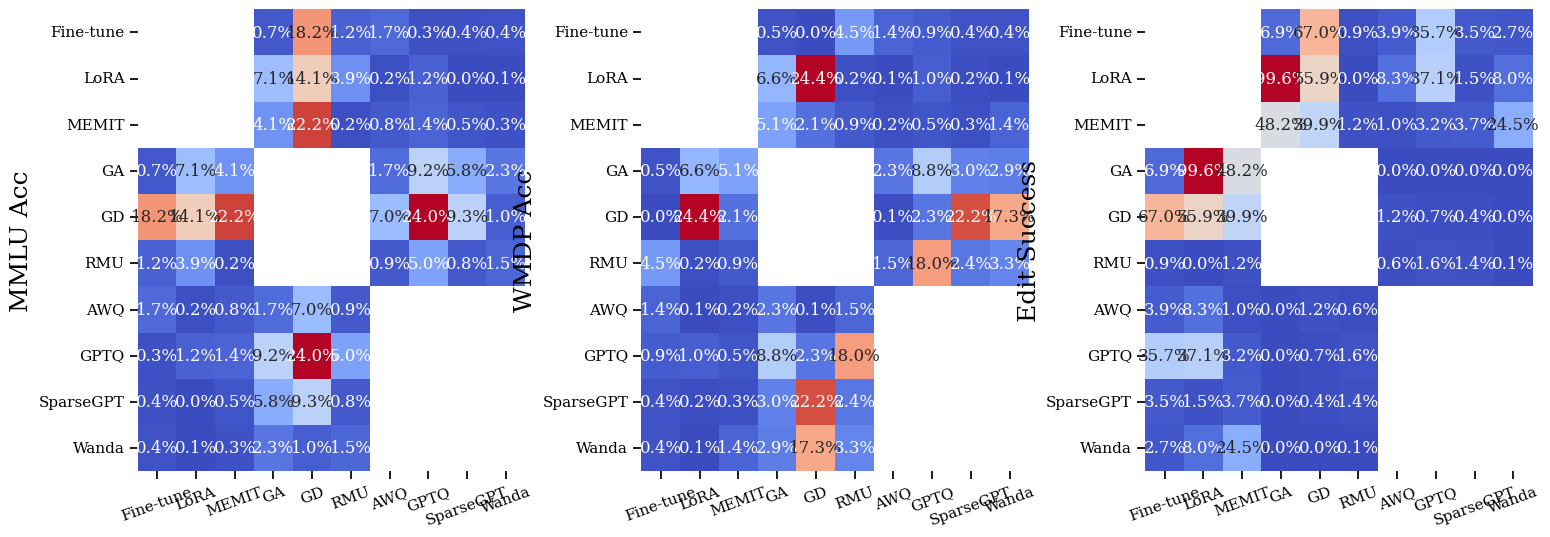

In [17]:
# Create three heatmaps next two eachother, one for each frame
fig, axes = plt.subplots(1, 3, figsize=(6 * FIG_SIZE, 2 * FIG_SIZE))
y_labels = {
    0: "MMLU Acc",
    1: "WMDP Acc",
    2: "Edit Success"
}

sns.heatmap(mmlu_heatmap_data, annot=True, fmt=".1%", cmap="coolwarm", ax=axes[0], cbar=False)
sns.heatmap(wmdp_heatmap_data, annot=True, fmt=".1%", cmap="coolwarm", ax=axes[1], cbar=False)
sns.heatmap(rewrite_heatmap_data, annot=True, fmt=".1%", cmap="coolwarm", ax=axes[2], cbar=False)

# roate x labels
for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=X_LABEL_ROTATION)

for i, ax in enumerate(axes):
    ax.set_ylabel(y_labels[i], fontsize=TITLE_FONT_SIZE)

# add padding for labels
fig.subplots_adjust(wspace=WSPACE, hspace=WSPACE)

if not os.path.exists("figures"):
    os.makedirs("figures")

plt.savefig("figures/delta_heatmaps.pdf", bbox_inches="tight")

## Plot: Editing under Compression 

In [18]:
def get_order_label(row):
    interventions = row["interventions"]
    first_method = ""
    second_method = ""
    if interventions[0] == "edit":
        first_method = row["edit"]
    elif interventions[0] == "compress":
        first_method = row["compression"]
    elif interventions[0] == "unlearn":
        first_method = row["unlearn"]
    
    if interventions[1] == "edit":
        second_method = row["edit"]
    elif interventions[1] == "compress":
        second_method = row["compression"]
    elif interventions[1] == "unlearn":
        second_method = row["unlearn"]
    
    return f"{first_method}→{second_method}"

def wrap_label(interventions):
    first_intervention, second_intervention = interventions[0], interventions[1]
    first_letter_upper = first_intervention[0].upper()
    second_letter_upper = second_intervention[0].upper()
    
    # EX: E $\rightarrow$ C
    return f"{first_letter_upper}$\\rightarrow${second_letter_upper}"


### Create mock records for baselines

In [19]:
# I want instances where editing has been applied but there is no unlearning or compression. In these cases, set wbits=16 and sparsity=0 
baseline_editors = data[(data["edit"].notnull()) & (data["unlearn"].isnull()) & (data["compression"].isnull()) & (data["interventions"].apply(lambda x: x == ["edit"]))].copy()
baseline_editors["wbits"] = 16
baseline_editors["sparsity_ratio"] = 0
news_records = []

# Edit and Compress
for editing_method in ["LoRA", "MEMIT", "Fine-tune"]:
    baseline_record = baseline_editors[baseline_editors["edit"] == editing_method]
    for compression_method in ["SparseGPT", "Wanda", "GPTQ", "AWQ"]:
        edit_first_record = baseline_record.copy()
        edit_first_record["compression"] = compression_method
        edit_first_record["interventions"] = [["edit", "compress"]]
        news_records.append(edit_first_record)

        compress_first_record = baseline_record.copy()
        compress_first_record["compression"] = compression_method
        compress_first_record["interventions"] = [["compress", "edit"]]
        news_records.append(compress_first_record)

baseline_unlearners = data[(data["edit"].isnull()) & (data["unlearn"].notnull()) & (data["compression"].isnull()) & (data["interventions"].apply(lambda x: x == ["unlearn"]))].copy()

# Compress and Unlearn
for unlearn_method in ["RMU"]:
    baseline_record = baseline_unlearners[baseline_unlearners["unlearn"] == unlearn_method]

    for compression_method in ["SparseGPT", "Wanda", "GPTQ", "AWQ"]:
        compress_first_record = baseline_record.copy()
        compress_first_record["unlearn"] = unlearn_method
        compress_first_record["compression"] = compression_method
        compress_first_record["interventions"] = [["compress", "unlearn"]]
        news_records.append(compress_first_record)

        unlearn_first_record = baseline_record.copy()
        unlearn_first_record["unlearn"] = unlearn_method
        unlearn_first_record["compression"] = compression_method
        unlearn_first_record["interventions"] = [["unlearn", "compress"]]
        news_records.append(unlearn_first_record)

baseline_records = pd.concat(news_records)

### Combined Pruning and Quantization

In [20]:
# Add mock baseline records to the frame used for plotting
data = pd.concat([data, baseline_records])

/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_74937/533696548.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pruning_frame["order"] = pruning_frame.apply(get_order_label, axis=1)
/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_74937/533696548.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_line["label"] = first_line["order"].apply(wrap_label)
/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_74937/533696548.py:49: SettingWithCopyWarning: 
A value is trying to

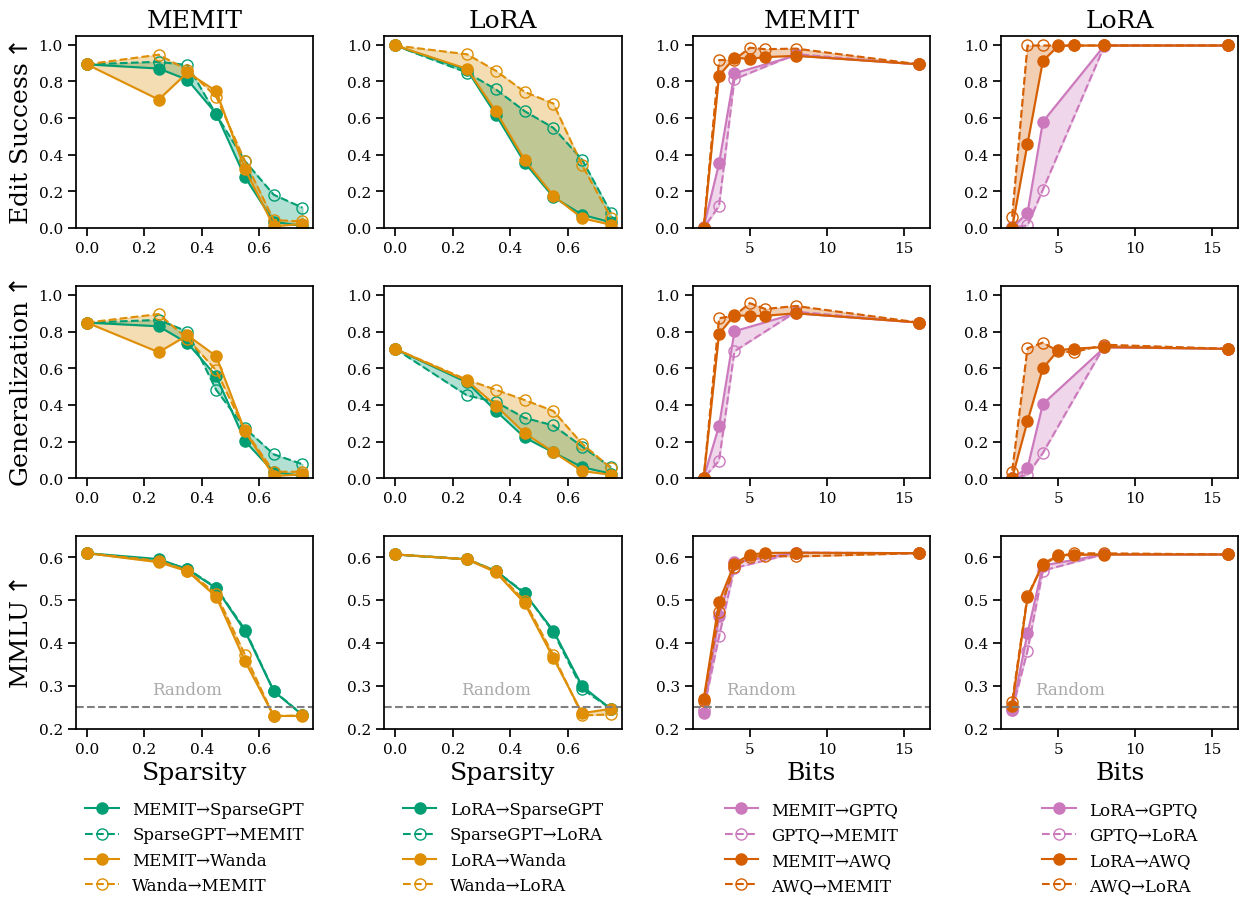

In [21]:
pruning_frame = data[((data["compression"] == "SparseGPT") | (data["compression"] == "Wanda")) & (data["edit"] != None) & (data["interventions"].apply(lambda x: len(x) > 1))]
# pruning_frame = pruning_frame[pruning_frame["edit"] != "Fine-tune"]
pruning_frame["order"] = pruning_frame.apply(get_order_label, axis=1)
pruning_frame = pruning_frame.sort_values(by="order")

quantization_frame = data[((data["compression"] == "GPTQ") | (data["compression"] == "AWQ")) & (data["edit"] != None) & (data["interventions"].apply(lambda x: len(x) > 1))]
quantization_frame = quantization_frame[quantization_frame["edit"] != "Fine-tune"]
quantization_frame["order"] = quantization_frame.apply(get_order_label, axis=1)
quantization_frame = quantization_frame.sort_values(by="order")

# 4 columns and 3 rows
fig, axes = plt.subplots(3, 4, figsize=(5 * FIG_SIZE, 3 * FIG_SIZE))
row_metrics = {
    0: "Rewrite accuracy",
    1: "Generalization",
    2: "mmlu accuracy",
}
row_labels = {
    0: r"Edit Success$ \uparrow$",
    1: r"Generalization$ \uparrow$",
    2: r"MMLU$ \uparrow$"
}
column_edit_methods = {
    0: "MEMIT",
    1: "LoRA",
    2: "MEMIT",
    3: "LoRA",
}

compositions_by_col = {
    # MEMIT and WANDA + SparseGPT
    0: [("MEMIT→SparseGPT", "SparseGPT→MEMIT"), ("MEMIT→Wanda", "Wanda→MEMIT")],
    # LoRA and WANDA + SparseGPT
    1: [("LoRA→SparseGPT", "SparseGPT→LoRA"), ("LoRA→Wanda", "Wanda→LoRA")],
    # MEMIT and GPTQ + AWQ
    2: [("MEMIT→GPTQ", "GPTQ→MEMIT"), ("MEMIT→AWQ", "AWQ→MEMIT")],
    # LoRA and GPTQ + AWQ
    3: [("LoRA→GPTQ", "GPTQ→LoRA"), ("LoRA→AWQ", "AWQ→LoRA")],
}
for row_index, y_metric in row_metrics.items():
    for col_index, plotting_frame in enumerate([pruning_frame, pruning_frame, quantization_frame, quantization_frame]):
        ax = axes[row_index][col_index]
        x_metric = "sparsity_ratio" if col_index < 2 else "wbits"
        plotting_frame = plotting_frame[plotting_frame["edit"] == column_edit_methods[col_index]]

        for composition in compositions_by_col[col_index]:
            compression_method = [method for method in composition[0].split("→") if method not in ["MEMIT", "LoRA", "Fine-tune"]][0]
            first_line = plotting_frame[plotting_frame["order"] == composition[0]]
            first_line["label"] = first_line["order"].apply(wrap_label)
            second_line = plotting_frame[plotting_frame["order"] == composition[1]].sort_values(x_metric)
            second_line["label"] = second_line["order"].apply(wrap_label)
            if compression_method in ["AWQ", "GPTQ"]:
                first_line = first_line.sort_values(x_metric, ascending=False)
                second_line = second_line.sort_values(x_metric, ascending=False)
            else:
                first_line = first_line.sort_values(x_metric)
                second_line = second_line.sort_values(x_metric)

            ax.plot(first_line[x_metric], first_line[y_metric], marker="o", markersize=MARKER_SIZE, color=colors[compression_method], label=f"{composition[0]}")
            ax.plot(second_line[x_metric], second_line[y_metric], markerfacecolor='none', marker="o", ls="--", markersize=MARKER_SIZE, color=colors[compression_method], label=f"{composition[1]}")
            ax.fill_between(
                x=first_line[x_metric], y1=first_line[y_metric], y2=second_line[y_metric],
                alpha=0.3,
                color=colors[compression_method]
            )

        if row_index != 2:
            ax.set_ylim(0, 1.05)
        else:
            ax.set_ylim(0.2, 0.65)
            ax.axhline(y=0.25, color="gray", linestyle="--")
            if col_index < 2:
                ax.text(0.35, 0.28, "Random", color="darkgray", ha="center")
            else:
                ax.text(8, 0.28, "Random", color="darkgray", ha="right")

        if row_index == 0:
            title = column_edit_methods[col_index]
            ax.set_title(title, fontsize=TITLE_FONT_SIZE)
        else:
            ax.set_title("")

        if col_index == 0:
            ax.set_ylabel(row_labels[row_index], fontsize=TITLE_FONT_SIZE)
        else:
            ax.set_ylabel("")

        if row_index == 2:
            ax.set_xlabel("Sparsity" if col_index < 2 else "Bits", fontsize=TITLE_FONT_SIZE)
        else:
            ax.set_xlabel("")

        if row_index == 2:
            ax.legend(fontsize=LEGEND_FONT_SIZE, frameon=False, loc="upper center", bbox_to_anchor=(0.5, -0.3), ncol=1)

fig.subplots_adjust(wspace=WSPACE, hspace=WSPACE)
plt.savefig("figures/main_results_editors_compression.pdf", bbox_inches="tight")

### 3 X 3 for Pruning and Quantization (Two Plots)

In [22]:
compositions_by_col = {
    # MEMIT and WANDA + SparseGPT
    0: [("MEMIT→SparseGPT", "SparseGPT→MEMIT"), ("MEMIT→Wanda", "Wanda→MEMIT")],
    # LoRA and WANDA + SparseGPT
    1: [("LoRA→SparseGPT", "SparseGPT→LoRA"), ("LoRA→Wanda", "Wanda→LoRA")],
    # FT and WANDA + SparseGPT
    2: [("Fine-tune→SparseGPT", "SparseGPT→Fine-tune"), ("Fine-tune→Wanda", "Wanda→Fine-tune")],
    # MEMIT and GPTQ + AWQ
    3: [("MEMIT→GPTQ", "GPTQ→MEMIT"), ("MEMIT→AWQ", "AWQ→MEMIT")],
    # LoRA and GPTQ + AWQ
    4: [("LoRA→GPTQ", "GPTQ→LoRA"), ("LoRA→AWQ", "AWQ→LoRA")],
    # FT and GPTQ + AWQ
    5: [("Fine-tune→GPTQ", "GPTQ→Fine-tune"), ("Fine-tune→AWQ", "AWQ→Fine-tune")],
}

In [23]:
pruning_frame["edit"].value_counts()

Fine-tune    28
LoRA         28
MEMIT        28
Name: edit, dtype: int64

/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_74937/739392040.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pruning_frame["order"] = pruning_frame.apply(get_order_label, axis=1)
/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_74937/739392040.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantization_frame["order"] = quantization_frame.apply(get_order_label, axis=1)
/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_74937/739392040.py:53: SettingWithCopyWarning: 
A

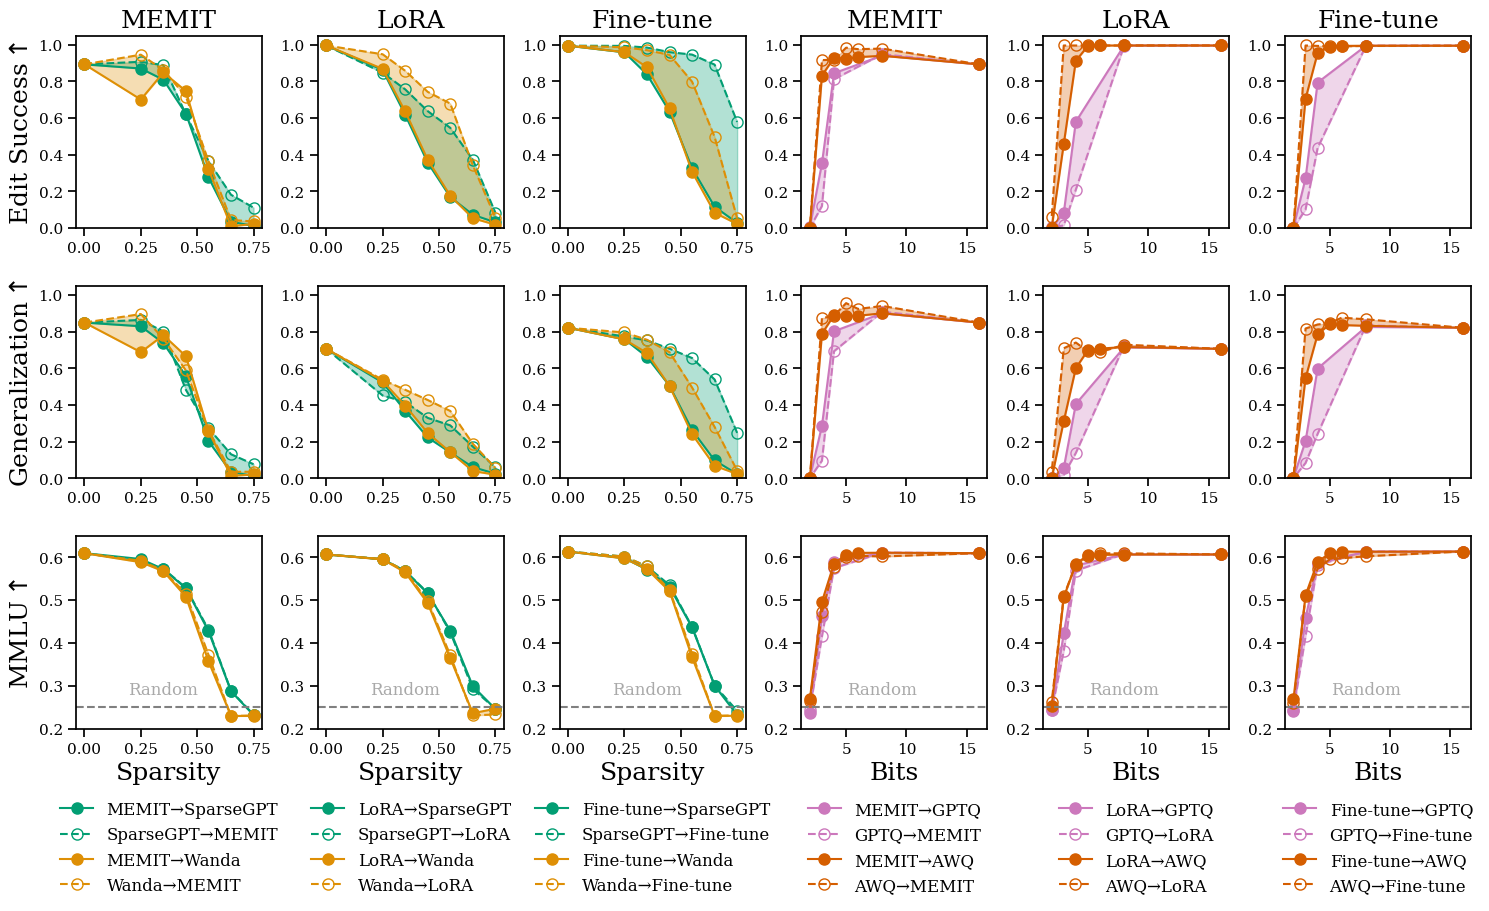

In [24]:
pruning_frame = data[((data["compression"] == "SparseGPT") | (data["compression"] == "Wanda")) & (data["edit"] != None) & (data["interventions"].apply(lambda x: len(x) > 1))]
pruning_frame["order"] = pruning_frame.apply(get_order_label, axis=1)
pruning_frame = pruning_frame.sort_values(by="order")

quantization_frame = data[((data["compression"] == "GPTQ") | (data["compression"] == "AWQ")) & (data["edit"] != None) & (data["interventions"].apply(lambda x: len(x) > 1))]
quantization_frame["order"] = quantization_frame.apply(get_order_label, axis=1)
quantization_frame = quantization_frame.sort_values(by="order")

# 4 columns and 3 rows
fig, axes = plt.subplots(3, 6, figsize=(6 * FIG_SIZE, 3 * FIG_SIZE))
row_metrics = {
    0: "Rewrite accuracy",
    1: "Generalization",
    2: "mmlu accuracy",
}
row_labels = {
    0: r"Edit Success$ \uparrow$",
    1: r"Generalization$ \uparrow$",
    2: r"MMLU$ \uparrow$"
}
column_edit_methods = {
    0: "MEMIT",
    1: "LoRA",
    2: "Fine-tune",
    3: "MEMIT",
    4: "LoRA",
    5: "Fine-tune"
}

compositions_by_col = {
    # MEMIT and WANDA + SparseGPT
    0: [("MEMIT→SparseGPT", "SparseGPT→MEMIT"), ("MEMIT→Wanda", "Wanda→MEMIT")],
    # LoRA and WANDA + SparseGPT
    1: [("LoRA→SparseGPT", "SparseGPT→LoRA"), ("LoRA→Wanda", "Wanda→LoRA")],
    # FT and WANDA + SparseGPT
    2: [("Fine-tune→SparseGPT", "SparseGPT→Fine-tune"), ("Fine-tune→Wanda", "Wanda→Fine-tune")],
    # MEMIT and GPTQ + AWQ
    3: [("MEMIT→GPTQ", "GPTQ→MEMIT"), ("MEMIT→AWQ", "AWQ→MEMIT")],
    # LoRA and GPTQ + AWQ
    4: [("LoRA→GPTQ", "GPTQ→LoRA"), ("LoRA→AWQ", "AWQ→LoRA")],
    # FT and GPTQ + AWQ
    5: [("Fine-tune→GPTQ", "GPTQ→Fine-tune"), ("Fine-tune→AWQ", "AWQ→Fine-tune")],
}
for row_index, y_metric in row_metrics.items():
    for col_index, plotting_frame in enumerate([pruning_frame, pruning_frame, pruning_frame, quantization_frame, quantization_frame, quantization_frame]):
        ax = axes[row_index][col_index]
        x_metric = "sparsity_ratio" if col_index < 3 else "wbits"
        plotting_frame = plotting_frame[plotting_frame["edit"] == column_edit_methods[col_index]]

        for composition in compositions_by_col[col_index]:
            compression_method = [method for method in composition[0].split("→") if method not in ["MEMIT", "LoRA", "Fine-tune"]][0]
            first_line = plotting_frame[plotting_frame["order"] == composition[0]]
            first_line["label"] = first_line["order"].apply(wrap_label)
            second_line = plotting_frame[plotting_frame["order"] == composition[1]].sort_values(x_metric)
            second_line["label"] = second_line["order"].apply(wrap_label)
            if compression_method in ["AWQ", "GPTQ"]:
                first_line = first_line.sort_values(x_metric, ascending=False)
                second_line = second_line.sort_values(x_metric, ascending=False)
            else:
                first_line = first_line.sort_values(x_metric)
                second_line = second_line.sort_values(x_metric)

            ax.plot(first_line[x_metric], first_line[y_metric], marker="o", markersize=MARKER_SIZE, color=colors[compression_method], label=f"{composition[0]}")
            ax.plot(second_line[x_metric], second_line[y_metric], markerfacecolor='none', marker="o", ls="--", markersize=MARKER_SIZE, color=colors[compression_method], label=f"{composition[1]}")
            ax.fill_between(
                x=first_line[x_metric], y1=first_line[y_metric], y2=second_line[y_metric],
                alpha=0.3,
                color=colors[compression_method]
            )

        if row_index != 2:
            ax.set_ylim(0, 1.05)
        else:
            ax.set_ylim(0.2, 0.65)
            ax.axhline(y=0.25, color="gray", linestyle="--")
            if col_index < 3:
                ax.text(0.35, 0.28, "Random", color="darkgray", ha="center")
            else:
                ax.text(8, 0.28, "Random", color="darkgray", ha="center")

        if row_index == 0:
            title = column_edit_methods[col_index]
            ax.set_title(title, fontsize=TITLE_FONT_SIZE)
        else:
            ax.set_title("")

        if col_index == 0:
            ax.set_ylabel(row_labels[row_index], fontsize=TITLE_FONT_SIZE)
        else:
            ax.set_ylabel("")

        if row_index == 2:
            ax.set_xlabel("Sparsity" if col_index < 3 else "Bits", fontsize=TITLE_FONT_SIZE)
        else:
            ax.set_xlabel("")

        if row_index == 2:
            ax.legend(fontsize=LEGEND_FONT_SIZE, frameon=False, loc="upper center", bbox_to_anchor=(0.5, -0.3), ncol=1)

fig.subplots_adjust(wspace=WSPACE, hspace=WSPACE)
plt.savefig("figures/main_results_editors_compression_with_ft.pdf", bbox_inches="tight")

## Plot: Unlearning under Compression 

/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_74937/1421480406.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pruning_frame["Avg WMDP"] = (pruning_frame["wmdp_bio accuracy"] + pruning_frame["wmdp_cyber accuracy"]) / 2
/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_74937/1421480406.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pruning_frame["order"] = pruning_frame.apply(get_order_label, axis=1)
/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_74937/1421480406.py

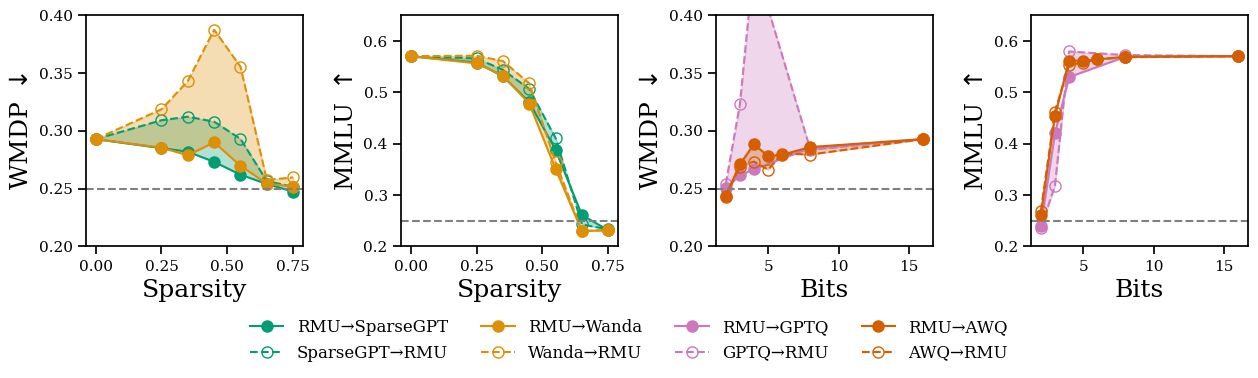

In [25]:
pruning_frame = data[((data["compression"] == "SparseGPT") | (data["compression"] == "Wanda")) & (data["unlearn"] == "RMU")]
pruning_frame["Avg WMDP"] = (pruning_frame["wmdp_bio accuracy"] + pruning_frame["wmdp_cyber accuracy"]) / 2
pruning_frame["order"] = pruning_frame.apply(get_order_label, axis=1)
pruning_frame = pruning_frame.sort_values(by="order")

quantization_frame = data[((data["compression"] == "GPTQ") | (data["compression"] == "AWQ")) & (data["unlearn"] == "RMU")]
quantization_frame["Avg WMDP"] = (quantization_frame["wmdp_bio accuracy"] + quantization_frame["wmdp_cyber accuracy"]) / 2
quantization_frame["order"] = quantization_frame.apply(get_order_label, axis=1)
quantization_frame = quantization_frame.sort_values(by="order", ascending=False)

fig, axes = plt.subplots(1, 4, figsize=(5 * FIG_SIZE, FIG_SIZE))
column_metrics = {
    0: "Avg WMDP",
    1: "mmlu accuracy",
    2: "Avg WMDP",
    3: "mmlu accuracy",
}
x_labels = {
    "sparsity_ratio": "Sparsity",
    "wbits": "Bits"
}
y_label = {
    "Avg WMDP": r"WMDP $\downarrow$",
    "mmlu accuracy": r"MMLU $\uparrow$"
}

# Custom legend elements
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='b', markersize=MARKER_SIZE, label='Edit→Compress'),
    plt.Line2D([0], [0], marker='x', color='w', markerfacecolor='r', markersize=MARKER_SIZE, label='Compress→Edit'),
]

for col_index, plotting_frame in enumerate([pruning_frame, pruning_frame, quantization_frame, quantization_frame]):
    x_metric = "sparsity_ratio" if col_index < 2 else "wbits"
    y_metric = "Avg WMDP" if col_index % 2 == 0 else "mmlu accuracy"
    ax = axes[col_index]
    ax.legend(title="Order", loc="upper left")
    # sns.lineplot(data=plotting_frame, x=x_metric, y=y_metric, hue="order", ax=ax, marker="o", markersize=MARKER_SIZE, linewidth=LINE_WIDTH)

    # Share area between compositions
    orders_pairs = [("RMU→SparseGPT", "SparseGPT→RMU"), ("RMU→Wanda", "Wanda→RMU"), ("RMU→GPTQ", "GPTQ→RMU"), ("RMU→AWQ", "AWQ→RMU")]
    for order_pair in orders_pairs:
        compression_method = [method for method in order_pair[0].split("→") if method != "RMU"][0]
        first_line = plotting_frame[plotting_frame["order"] == order_pair[0]].sort_values(x_metric)
        ax.plot(first_line[x_metric], first_line[y_metric], marker="o", markersize=MARKER_SIZE, color=colors[compression_method], label=f"{order_pair[0]}")
        
        second_line = plotting_frame[plotting_frame["order"] == order_pair[1]].sort_values(x_metric)
        ax.plot(second_line[x_metric], second_line[y_metric], markerfacecolor='none', marker="o", ls="--", markersize=MARKER_SIZE, color=colors[compression_method], label=f"{order_pair[1]}")
        
        ax.fill_between(
            x=first_line[x_metric], y1=first_line[y_metric], y2=second_line[y_metric],
            alpha=0.3,
            color=colors[compression_method]
        )

    ax.set_xlabel(x_labels[x_metric], fontsize=TITLE_FONT_SIZE)
    ax.set_ylabel(y_label[column_metrics[col_index]], fontsize=TITLE_FONT_SIZE)

    ax.legend(frameon=False)
    if col_index == 0:
        ax.legend(loc="upper center", bbox_to_anchor=(2.5, -0.25), ncol=4, frameon=False, fontsize=LEGEND_FONT_SIZE)
    else:
        ax.get_legend().remove()

    ax.axhline(y=0.25, color="gray", linestyle="--")

    if y_metric == "mmlu accuracy":
        ax.set_ylim(0.2, 0.65)
    else:
        ax.set_ylim(0.2, 0.4)

# add padding for labels
fig.subplots_adjust(wspace=WSPACE + 0.15, hspace=WSPACE)
plt.savefig("figures/unlearning_compression_1x4.pdf", bbox_inches="tight")
